# <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:orange">Project Approach</font>

This project uses 

- pretrained segmentation models and decoders from the [Segmentation Models Pytorch](https://github.com/qubvel/segmentation_models.pytorch) library,

- optional geometric and pixel-level data augmentation transforms from the [Albumentations](https://albumentations.ai/) library,

- optional copy-paste data augmentation,

- optional overlapping tiling of multi-scaled training images,

- weighted soft-dice loss function adapted from the [Pytorch Toolbelt](https://github.com/BloodAxe/pytorch-toolbelt) library,

- ranger optimizer from lessw2020's [GitHub](https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer) repository,

- a constant learning rate until the trainer loses patience followed by a cosine annealing, and

- ensembles that combine pixel-level probabilities.

**Notes:** The copy-paste data augmentation loosely follows the technique presented in the [Simple Copy-Paste is a Strong Data Augmentation Method for Instance Segmentation](https://arxiv.org/pdf/2012.07177v1.pdf)  paper. PyTorch Toolbelt's soft dice loss function was modified to allow for one-hot encoded masks and per-class weighting was added.The Ranger optimizer is a combination of RAdam and LookAhead as explained in [New Deep Learning Optimizer, Ranger: Synergistic combination of RAdam + LookAhead for the best of both](https://lessw.medium.com/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d). Despite trying to eliminate training variability to make experiments deterministic and repeatable, small variations occur between runs. Since I could not locate the source of this randomness and decided to live with it, I enabled CUDNN benchmarking.

The choice of optimizer and LR scheduler was informed by [How we beat the FastAI leaderboard score by +19.77%: a synergy of new deep learning techniques for your consideration](https://lessw.medium.com/how-we-beat-the-fastai-leaderboard-score-by-19-77-a-cbb2338fab5c).

> **Optimizer:** Adam, introduced in 2015, has been the default optimizer for deep learning for many years. Ranger is a combination of two recent innovations that build on top of Adam — Rectified Adam, and Lookahead.
> Rectified Adam (RAdam) was the result of Microsoft research looking into why all adaptive optimizers need a warm-up or else they often shoot into bad optima at the start of training. Most everyone was aware a warm-up was needed to get better results with Adam, but researchers Liu, Jian, He et al made the effort to understand why. The answer was because Adam (and all adaptive optimizers) are making premature jumps when the variance of the adaptive learning rate is too high. Adam needs to wait to see more data to really start making larger decisions. RAdam achieves this automatically by adding in a rectifier that dynamically tamps down the adaptive learning rate until the variance stabilizes. Thus, your training gets off to a solid start intrinsically, with no warmup needed!
> LookAhead was developed in part by Geoffrey Hinton and keeps a separate set of weights from the optimizer. Then every k steps (5 or 6), it interpolates between it’s weights and the optimizer’s faster weights, and then splits the difference and updates the faster optimizer. The result is like having a buddy system to explore the loss terrain. The faster optimizer, RAdam for Ranger, explores the terrain as usual. LookAhead stays a bit behind and lets it scout things out, while making sure it can be pulled back if it’s a bad optima. Thus, safer / better exploration and faster convergence.

> **LR Scheduler:** FastAI has traditionally used a ramp up, ramp down curve for the learning rates during training. The idea is likely based on the need for a warmup (see above), but also the ramp up and ramp down are designed to help the optimizer ‘jump’ over smaller local minima. It’s been quite successful with Adam. However, it became apparent that the newer optimizers just did not do well that approach. GRankin thus developed a ‘flat + cosine anneal’ training curve, and that immediately jumped the results we saw with Ranger. In theory, the improvements from this new training curve are that by stabilizing the learning rate, we are letting RAdam properly get training off to a solid start, and then letting LookAhead explore in a steadier manner. Constantly changing the learning rates seems to negatively impact the exploration process.

The first experiment, `ExpAAA`, used a one cycle LR scheduler. Subsequent experiments switched to a ‘flat + cosine anneal’ training curve where training occurs over primary and annealing stages. The primary stage uses a constant learning rate of `SOLVER.MAX_LR`. After each epoch, the trainer creates a _last_ checkpoint and a _best_ checkpoint if the validation loss reached a new minimum. Primary training stops after `SOLVER.NUM_EPOCHS` epochs or `SOLVER.PATIENCE` epochs where the validation loss does not decrease. Prior to the annealing stage, the trainer reverts to the _best_ checkpoint. It then uses a cosine annealing scheduler to drop the LR from `SOLVER.MAX_LR` to `SOLVER.MIN_LR` over `SOLVER.ANN_EPOCHS`. The choice of `SOLVER.MAX_LR` is informed by a _LR sweep test_, which plots the validation loss as a function of LR. The optimal LR is where the model learns the fastest, i.e., the reduction in validation loss is the greatest.

This project ran experiments to test the impact of the following techniques on the validation dataset's mean Dice score. Unless noted, these experiments used a FPN model with EfficientNet-B3 encoder.

- data augmentation (positive impact)
- overlapping tiles on multi-scale training images (positive impact for ½-size tiles, negative impact for ⅓-size tiles)
- a DeepLab3+ model w/ EfficientNet and ResNet encoders (negligible impact at expense of significant increase in training time)
- a Linknet model w/ SK-ResNe(X)t encoder (negative impact)
- a TIMM-ResNest50d encoder (negligible impact at expense of significant increase in training time)
- ensembles over systematic slices of public dataset (positive impact)
- further train previous experiment w/ lower LR and full-size images or ½-size tiles (minor impact)
- weighted soft-dice loss function (minor positive to negative impact depending upon weights)
- copy-paste data augmentation (neglibly to negative impact)
- adaptive loss function weights and copy-paste class weights (negibly to negative impact)


## Lessons Learned

I made the following observations.

1. Surprisingly, the FPN model with an EfficientB3 encoder performed better than DeepLabV3+ models with EfficientB3, ResNet50, and ResNet152 encoders.

2. Another surprise was the FPN model with an EfficientB3 encoder, unlike other models. did not fully converge with larger batch sizes.

3. It was interesting to observe at what point during training the model began to properly classify specific classes.

4. Weighting the soft dice loss function was finicky. It may be possible to improve the mean dice score by tweaking the per-class weights. However, there is a greater chance that weighting will decrease the mean dice score.
   
5. I had high expectations for the copy-paste data augmentation. Unfortunately, the random and weighted variants did improve the mean dice score even with more complicated models.

## Remaining Question

Models often require the image dimension to be divisible by a power of 2, e.g., 32. Papers, in general, did not discuss how they handled padding.

* Should it be its own class? 
* Should it count as background? 
* Should it be ignored from the loss function?

Messou in his master's thesis, [Handling Invalid Pixels in Convolutional Neural Networks](https://vtechworks.lib.vt.edu/handle/10919/98619), investigates two methods, partial and edge convolutional, to handle border and internal padding. I did not want to change the model architecture, so I did not implement either method.

## <font style="color:orange">Download and Unzip the Dataset</font>

The `download_and_unzip_dataset()` function downloads and unzips the project's dataset. Since this dataset is stored on kaggle, this function requires the user to manually download their credentials from kaggle and place the credential file, `kaggle.json` in the same directory as this notebook. The output of the aforementioned function will be similar to the following.

```
Requirement already satisfied: kaggle in /root/miniconda/lib/python3.7/site-packages (1.5.10)
Requirement already satisfied: tqdm in /root/miniconda/lib/python3.7/site-packages (from kaggle) (4.47.0)
Requirement already satisfied: python-dateutil in /root/miniconda/lib/python3.7/site-packages (from kaggle) (2.8.1)
...

total 4.0K
-rw-r--r-- 1 root root 68 Feb 20 19:33 kaggle.json

ref                             title               author        lastRunTime          totalVotes  
------------------------------  ------------------  ------------  -------------------  ----------  
kevinkramer/notebookeafa5161c4  notebookeafa5161c4  Kevin Kramer  2021-01-09 21:40:41           0  

Downloading and unzipping dataset ...
Downloading opencv-pytorch-course-segmentation.zip to /home/kevinkramer/class/week12/project4
100%|████████████████████████████████████████| 738M/738M [00:18<00:00, 41.5MB/s]
```

In [1]:
def init_kaggle():
    import os

    # install kaggle api
    !pip install kaggle
    
    # copy credentials to the proper location
    # note: manually uploaded credential file
    if not os.path.exists("/root/.kaggle/kaggle.json"):
        !mkdir -p /root/.kaggle
        !cp kaggle.json /root/.kaggle/
        !ls -lh /root/.kaggle
        !chmod 600 /root/.kaggle/kaggle.json
        
    # verify kaggle is properly setup
    !kaggle kernels list --user kevinkramer --sort-by dateRun
    
def download_and_unzip_dataset():
    # download and unzip data file
    print("Downloading and unzipping dataset ...")
    !mkdir ./data
    !kaggle competitions download -c opencv-pytorch-course-segmentation
    !unzip -q opencv-pytorch-course-segmentation.zip -d ./data
    !rm opencv-pytorch-course-segmentation.zip
    

# uncomment the following lines to download and unzip the dataset    
# init_kaggle()
# download_and_unzip_dataset()

## <font style="color:orange">Install Project Dependencies</font>

The `install_project_dependencies()` function installs the project's dependencies. Its output will be similar to the following.

```
Collecting segmentation-models-pytorch
  Downloading segmentation_models_pytorch-0.1.3-py3-none-any.whl (66 kB)
     |████████████████████████████████| 66 kB 2.8 MB/s  eta 0:00:01
Requirement already satisfied: albumentations in /root/miniconda/lib/python3.7/site-packages (0.5.2)
...
```

**Note:** For convenience, I added albumentations and segmentation-models-pytorch to a Docker image along Python, Pytorch GPU, Jupyter notebook, etc.

In [2]:
def install_project_dependencies():
    !pip install -U albumentations
    !pip install -U segmentation-models-pytorch
    
# uncomment the following line to install the project dependencies
# install_project_dependencies()

## <font style="color:orange">Python Imports</font>

The following are common imports. If an import is only used by a function or two, then the import is declared in the function itself.

In [3]:
import os
import random
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools
import torch
import yaml
from IPython.utils import io
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from tqdm import tqdm


class classproperty(property):
    def __get__(self, cls, owner):
        return classmethod(self.fget).__get__(None, owner)()
    
tools.utils.seed_system(42)

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

## <font style="color:orange">Aeroscapes Data</font>

The `Data` class follows the [singleton design pattern](https://www.tutorialspoint.com/python_design_patterns/python_design_patterns_singleton.htm). It converts this project's public and private datasets into lists of "image dictionaries". This class also provides methods to split the public data into training and validation datasets as well as specify subsets of each to test the training pipeline.

In [4]:
class Data(object):
    __instance = None
    
    @classproperty
    def instance(cls):
        if cls.__instance == None:
            Data()
        return cls.__instance
    
    __data_dir = "./data"
    __img_dir = os.path.join(__data_dir, "imgs/imgs")
    __msk_dir = os.path.join(__data_dir, "masks/masks")
    __prv_img_csv_path = os.path.join(__data_dir, "test.csv")
    __pub_img_csv_path = os.path.join(__data_dir, "train.csv")

    @classproperty
    def data_dir(cls):
        return cls.__data_dir
    
    __classes = (        #  Value
    # ----------------   #  -----    
        "Background",    #    0
        "Person",        #    1
        "Bike",          #    2
        "Car",           #    3
        "Drone",         #    4
        "Boat",          #    5
        "Animal",        #    6
        "Obstacle",      #    7
        "Construction",  #    8
        "Vegetation",    #    9
        "Road",          #   10
        "Sky"            #   11
    )
    
    @classproperty
    def classes(cls):
        return cls.__classes
    
    @classproperty
    def num_classes(cls):
        return len(cls.__classes)
    
    @classproperty
    def image_dir(cls):
        return cls.__img_dir
    
    @classproperty
    def mask_dir(cls):
        return cls.__msk_dir
    
    @classmethod
    def class_index(cls, class_name):
        return cls.__classes.index(class_name)

    @classmethod
    def class_values(cls, classes):
        return [Data.class_index(cls) for cls in classes]
    
    __split_params = [
        (  2, 0.0000), (  3, 0.2000), (  5, 0.4000), (  7, 0.6000), ( 11, 0.8000),
        ( 13, 0.1000), ( 17, 0.3000), ( 19, 0.5000), ( 23, 0.7000), ( 29, 0.9000),
        ( 31, 0.0500), ( 37, 0.1500), ( 41, 0.2500), ( 43, 0.3500), ( 47, 0.4500),
        ( 53, 0.5500), ( 59, 0.6500), ( 61, 0.7500), ( 67, 0.8500), ( 71, 0.9500)
    ]
    
    @classmethod
    def split_params(cls, idx):
        return cls.__split_params[max(int(idx), 0)]
    
    ####################################################################################################
    
    def __init__(self):
        if Data.__instance != None:
            raise Exception("Data is a singleton. Use the Data.instance class property.")
        else:
            Data.__instance = self
            self.__prv_image_dict_list = self.__parse_image_data_file(Data.__prv_img_csv_path)
            self.__pub_image_dict_list = self.__parse_image_data_file(Data.__pub_img_csv_path)
            random.Random(42).shuffle(self.__pub_image_dict_list)

    def __parse_image_data_file(self, path):
        df = pd.read_csv(path, dtype={'ImageID': 'str'}, engine='python')
        image_dict_list = [self.__create_image_dict(idx, image_id) for idx, image_id in enumerate(df.values[:,0])]
        return image_dict_list

    def __create_image_dict(self, idx, image_id):
        img_dict = {}
        img_path = os.path.join(Data.__img_dir, image_id + ".jpg")
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image '{img_path}' is missing.")
        
        img_dict["id"] = idx
        img_dict["name"] = image_id
        img_dict["image_path"] = img_path
        img_dict["width"] = 1280
        img_dict["height"] = 720

        msk_path = os.path.join(Data.__msk_dir, image_id + ".png")
        if os.path.isfile(msk_path):
            img_dict["mask_path"] = msk_path
            
        return img_dict
    
    @property
    def prv_image_dict_len(self):
        return len(self.__prv_image_dict_list)
            
    @property
    def pub_image_dict_len(self):
        return len(self.__pub_image_dict_list)

    def get_prv_image_dict_list(self, indices=None):
        if indices is None:
            return self.__prv_image_dict_list
        return [self.__prv_image_dict_list[idx] for idx in indices]
    
    def get_pub_image_dict_list(self, indices=None):
        if indices is None:
            return self.__pub_image_dict_list
        return [self.__pub_image_dict_list[idx] for idx in indices]
    
    def split_pub_dataset(self, split_idx=0):
        split_len = len(self.__split_params)
        if split_idx >= split_len:
            raise ValueError(f"split_idx must an integer whose value is less than {split_len}")

        total_len = len(self.__pub_image_dict_list)
        valid_len = int(0.2 * total_len + 0.5)
        
        _, rel_off = Data.split_params(split_idx)
        abs_off = int(rel_off * total_len + 0.5)
        
        valid_idx = [(abs_off + idx) % total_len for idx in range(valid_len)]
        train_idx = [idx for idx in range(total_len) if idx not in valid_idx]
        
        if split_idx < 0:
            train_idx = self.__create_subset(train_idx, min(-0.01 * split_idx, 1.))
            valid_idx = self.__create_subset(valid_idx, min(-0.01 * split_idx, 1.))
        
        return train_idx, valid_idx
    
    @classmethod
    def __create_subset(cls, indices, subset_size=0.05):
        _, indices = np.unique([int(idx * subset_size) for idx in indices], return_index=True)
        return indices

## <font style="color:orange">Training/Validation Splitting Analysis</font>

To maximize the benefit of a model ensemble, the following conditions should be true.

- Each model should be trained on different slices of the public data.
- The public data should be equally represented in the aggregrated datasets.

The `analyze_data_splitting(splits)` function produced the following output, which validates the the aforementioned criteria are satisfied.

```
Concatentation of 5 Splits
train - len:  10485, min:  4, max:  5, ave:  4.0004
valid - len:   2620, min:  1, max:  1, ave:  1.0000

Concatentation of 10 Splits
train - len:  20970, min:  8, max:  9, ave:  8.0008
valid - len:   5240, min:  1, max:  2, ave:  1.9992

Concatentation of 20 Splits
train - len:  41940, min: 16, max: 17, ave: 16.0015
valid - len:  10480, min:  3, max:  4, ave:  3.9985
```

In [5]:
def analyze_data_splitting(splits):
    data = Data.instance
    train_indices = []
    valid_indices = []
    for split_idx in range(splits):
        train_idx, valid_idx = data.split_pub_dataset(split_idx)
        train_indices.extend(train_idx)
        valid_indices.extend(valid_idx)

    def print_stats(label, image_indices):
        unique, count = np.unique(image_indices, return_counts=True)
        print(label, end=" - ")
        print(f"len: {len(image_indices):>6}", end=", ")
        print(f"min: {np.min(count):>2}", end=", ")
        print(f"max: {np.max(count):>2}", end=", ")
        print(f"ave: {np.mean(count):7.04f}")

    print(f"Concatentation of {splits} Splits")
    print_stats("train", train_indices)
    print_stats("valid", valid_indices)
    print()
    

# uncomment the following lines to analyze the splitting of the public data       
#analyze_data_splitting(5)
#analyze_data_splitting(10)
#analyze_data_splitting(20)

## <font style="color:orange">ImageCache</font>

To decrease image and mask load and decoding time, the `ImageCache` class caches the images and masks as a large numpy array, which, once generated, can be cached to, and read from, disk. This class follows the [singleton design pattern](https://www.tutorialspoint.com/python_design_patterns/python_design_patterns_singleton.htm). Although this class did not decrease training time, it provides the capability of storing synthetic images and masks created by cutting classes from one image/mask pair and pasting them into another image/mask pair.

In [6]:
class ImageCache(object):
    __instance = None
    __cache_path = os.path.join(Data.data_dir, "cache.npy")
    
    @classproperty
    def instance(cls):
        if cls.__instance == None:
            ImageCache()
        return cls.__instance

    def __init__(self):
        if ImageCache.__instance != None:
            raise Exception("ImageCache is a singleton. Use the ImageCache.instance class property.")
        else:
            ImageCache.__instance = self
            if os.path.isfile(ImageCache.__cache_path):
                with open(ImageCache.__cache_path, "rb") as f:
                    self._img_data = np.load(f)
                    self._msk_data = np.load(f)               
            else:
                self.__create_cache()
                with open(ImageCache.__cache_path, "wb") as f:
                    np.save(f, self._img_data)
                    np.save(f, self._msk_data)
    
    def image(self, idx):
        return self._img_data[idx]
    
    def mask(self, idx):
        return self._msk_data[idx]

    def update(self, idx, image, mask):
        self._img_data[idx, ...] = image
        self._msk_data[idx, ...] = mask

    def __create_cache(self):
        image_dict_list = Data.instance.get_pub_image_dict_list()
        images = len(image_dict_list)
        self._msk_data = np.empty((images, 720, 1280), dtype=np.uint8)
        self._img_data = np.empty((images, 720, 1280, 3), dtype=np.uint8)
        pbar = tqdm(image_dict_list, desc="Loading", unit="image")
        for image_dict in pbar:
            idx = image_dict["id"]
            img = cv2.imread(image_dict["image_path"])
            self._img_data[idx, ...] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self._msk_data[idx, ...] = cv2.imread(image_dict["mask_path"], 0)
        pbar.close()


ImageCache.instance

## <font style="color:orange">Dataset</font>

The `Dataset` class specializes PyTorch's `torch.utils.data.Dataset` class. This loads images and/or masks from either disk or the ImageCache. It optionally performs geometric, tiling, and final transforms on images and masks and pixel-level transforms on images. It can optionally split the masks into "per class" binary masks.

**Note:** The final transforms prepare the images and masks for training and inferencing.

In [7]:
class Dataset(TorchDataset):
    def __init__(
        self,
        image_dict_list = None,
        classes = None,
        pixel_transforms = None,
        final_transforms = None,
        geometric_transforms = None,
        tile_transforms_list = None,
        binary_masks = False,
        use_image_cache = False
    ):
        self._image_dict_list = image_dict_list
        self._image_cache = ImageCache.instance if use_image_cache else None
        self._pixel_transforms = pixel_transforms
        self._final_transforms = final_transforms
        self._geometric_transforms = geometric_transforms
        self._tile_transforms_list = tile_transforms_list
        self._binary_masks = binary_masks

        self._classes = classes
        if classes is None:
            self._classes = Data.classes

        self._class_values = Data.class_values(self._classes)
        
        self._tiles_per_image = 1
        if tile_transforms_list is not None:
            self._tiles_per_image = len(tile_transforms_list)
    
    @property
    def classes(self):
        return self._classes
    
    @property
    def class_values(self):
        return self._class_values
    
    @classmethod
    def load(cls, image_dict, image_cache=None):
        if image_cache:
            idx = image_dict["id"]
            image = image_cache.image(idx)
            mask = image_cache.mask(idx)
        else:
            image = cv2.imread(image_dict["image_path"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = None
            if "mask_path" in image_dict:
                mask = cv2.imread(image_dict["mask_path"], 0)
        return image, mask
    
    def __len__(self):
        return len(self._image_dict_list) * self._tiles_per_image
    
    def __getitem__(self, idx):
        idx_dict = idx // self._tiles_per_image
        idx_tile = idx  % self._tiles_per_image
        image_dict = self._image_dict_list[idx_dict]       
        image, mask = Dataset.load(image_dict, self._image_cache)

        # handle the private dataset with images w/o masks
        if mask is None:
            if self._geometric_transforms:
                result = self._geometric_transforms(image=image)
                image = result["image"]

            if self._tile_transforms_list:
                result = self._tile_transforms_list[idx_tile](image=image)
                image = result["image"]

            if self._pixel_transforms:
                result = self._pixel_transforms(image=image)
                image = result["image"]

            if self._final_transforms:
                result = self._final_transforms(image=image)
                image = result["image"]

        # handle the public dataset with images and masks
        else:
            if self._geometric_transforms:
                result = self._geometric_transforms(image=image, mask=mask)
                image, mask = result["image"], result["mask"]

            if self._tile_transforms_list:
                result = self._tile_transforms_list[idx_tile](image=image, mask=mask)
                image, mask = result["image"], result["mask"]

            if self._binary_masks:
                mask = [(mask == v) for v in self._class_values]
                mask = np.stack(mask, axis=-1).astype("float32")

            if self._pixel_transforms:
                result = self._pixel_transforms(image=image)
                image = result["image"]            

            if self._final_transforms:
                result = self._final_transforms(image=image, mask=mask)
                image, mask = result["image"], result["mask"]            

        return image, mask

## <font style="color:orange">Copy-Paste Dataset</font>

The `CopyPasteDataset` class specializes PyTorch's `torch.utils.data.Dataset` class. Instances of this class return a set of image/mask pairs that are optionally geometrically transformed. These sets are used for copy-paste data synthesis.

**Note:** Call the `shuffle` method before a training epoch to randomize the paste and paste image/mask pairs.

In [8]:
class CopyPasteDataset(TorchDataset):
    def __init__(
        self,
        image_dict_list = None,
        geometric_transforms = None
    ):
        self._image_dict_list = image_dict_list
        self._shuffle = list(range(len(image_dict_list)))
        self._geometric_transforms = geometric_transforms

    def shuffle(self):
        random.shuffle(self._shuffle)

    def __load(self, image_dict):
        image = cv2.imread(image_dict["image_path"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(image_dict["mask_path"], 0)
        return image, mask
    
    def __len__(self):
        return len(self._image_dict_list)
    
    def __getitem__(self, idx):
        dict_copy = self._image_dict_list[self._shuffle[idx]]
        image_copy, mask_copy = self.__load(dict_copy)

        dict_paste = self._image_dict_list[idx]
        image_paste, mask_paste = self.__load(dict_paste)

        if self._geometric_transforms:
            result = self._geometric_transforms(image=image_copy, mask=mask_copy)
            image_copy, mask_copy = result["image"], result["mask"]

            result = self._geometric_transforms(image=image_paste, mask=mask_paste)
            image_paste, mask_paste = result["image"], result["mask"]

        idx = np.array(dict_paste["id"])
        pixel_counts = np.array(dict_copy["mask_pixel_counts"])
        return idx, image_copy, mask_copy, dict_paste, image_paste, mask_paste, pixel_counts

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

## <font style="color:orange">Visualizer</font>

The `Visualizer` class is static and contains to public methods: `visualize_images` and `blend_images`. The former plots an arbitrary number of images on a row. The latter alpha blends an image with predicted and/or ground truth masks. Both accept image and mask parameters as file path strings, numpy arrays, and tensors. Mask classes are depicted using the same colors as the [Aeroscapes](https://github.com/ishann/aeroscapes) dataset.

Samples without Alpha Blending


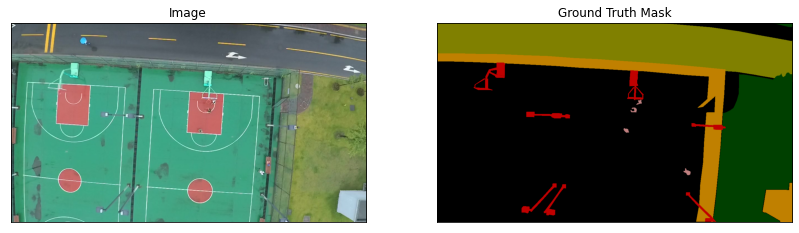

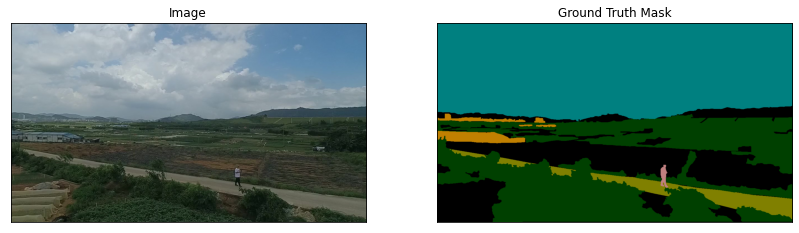

Samples with Alpha Blending


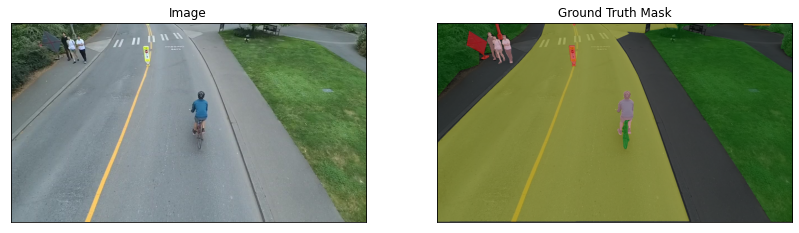

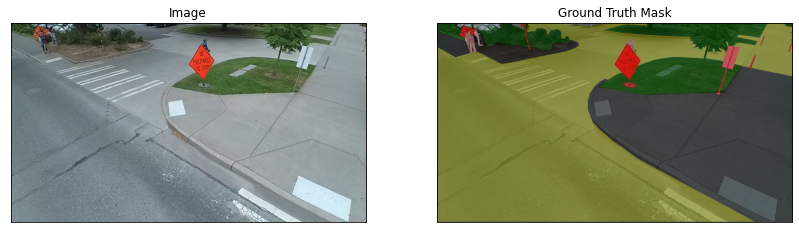

In [9]:
class Visualizer(object):
    __class_colors = (    #  Class 
    #------------------   #  -------------
        (  0,   0,   0),  #  Background
        (192, 128, 128),  #  Person
        (  0, 128,   0),  #  Bike
        (128, 128, 128),  #  Car
        (128,   0,   0),  #  Drone
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  Vegetation
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    )
    
    @classproperty
    def class_colors(cls):
        return cls.__class_colors
    
    @classmethod
    def create_color_mask(cls, mask):       
        return np.array(Visualizer.__class_colors)[mask.ravel()].reshape((*mask.shape, 3))
    
    @classmethod
    def _process_image(cls, name, image):
        is_path = isinstance(image, str)
        is_data = isinstance(image, np.ndarray)
        is_tensor = isinstance(image, torch.Tensor)
        if not is_path and not is_data and not is_tensor:
            raise ValueError(f"{name} must be a string path, numpy.ndarray, or torch.Tensor.")
            
        if "mask" in name:
            if is_tensor:
                image = image.cpu().numpy()
            elif is_path:
                image = cv2.imread(image, 0)
            image = cls.create_color_mask(image)
        elif is_tensor:
            image = image.cpu().numpy()
        elif is_path:
            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        return image
    
    @classmethod
    def visualize_images(cls, **images):
        """Plot images in one row."""
        n = len(images)
        plt.figure(figsize=(14, 5))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(cls._process_image(name, image))                   
        plt.show()

    @classmethod
    def blend_images(cls, image, pr_mask=None, gt_mask=None, alpha=0.5):
        ncols = 1
        if pr_mask is not None: ncols += 1
        if gt_mask is not None: ncols += 1
        if ncols == 1:
            raise ValueError("A predicted or ground truth mask is required")
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, ncols, 1)
        plt.xticks([])
        plt.yticks([])
        plt.title("Image")
        plt.imshow(cls._process_image("image", image))

        def blend(image, mask, title, alpha):
            plt.xticks([])
            plt.yticks([])
            plt.title(title)
            plt.imshow(cls._process_image("image", image))
            plt.imshow(cls._process_image("mask", mask), alpha=alpha)
        
        index = 1
        if gt_mask is not None:
            index += 1
            plt.subplot(1, ncols, index)
            blend(image, gt_mask, "Ground Truth Mask", alpha)
        if pr_mask is not None:
            index += 1
            plt.subplot(1, ncols, index)
            blend(image, pr_mask, "Predicted Mask", alpha)
        

print(f"Samples without Alpha Blending")
for image_dict in Data.instance.get_pub_image_dict_list(range(0, 2)):
    Visualizer.visualize_images(image=image_dict["image_path"], ground_truth_mask=image_dict["mask_path"])
print(f"Samples with Alpha Blending")
for image_dict in Data.instance.get_pub_image_dict_list(range(2, 4)):
    Visualizer.blend_images(image=image_dict["image_path"], gt_mask=image_dict["mask_path"], alpha=0.6)


## <font style="color:orange">Dataset Analysis</font>

The images in Aeroscapes dataset are 1280 x 720 pixels (720P). Given semantic segmentation classifies each pixel in an image, it is useful to see whether the classes are balanced. The `compute_class_counts()` function processes all the masks in the public datset and tallies the number of pixels in each class. Tallies are added to image dictionaries as well as cached to avoid repeated lengthy computation. Since this dataset is very imbalanced, the `plot_class_counts(class_counts)` function plots the class counts on a log scale. Each bar is colored according to its class color.

```
Analyzing: 100%|██████████| 2621/2621 [00:27<00:00, 94.36mask/s]

image_counts = [2621, 2223, 1091, 762, 264, 49, 73, 1732, 1455, 2414, 2294, 388]

pixel_counts = [555900697, 10402499,  1531710,   8283476,    650353,    548987,
                  1663688, 14487197, 91507497, 854898289, 763651425, 111987782]
```

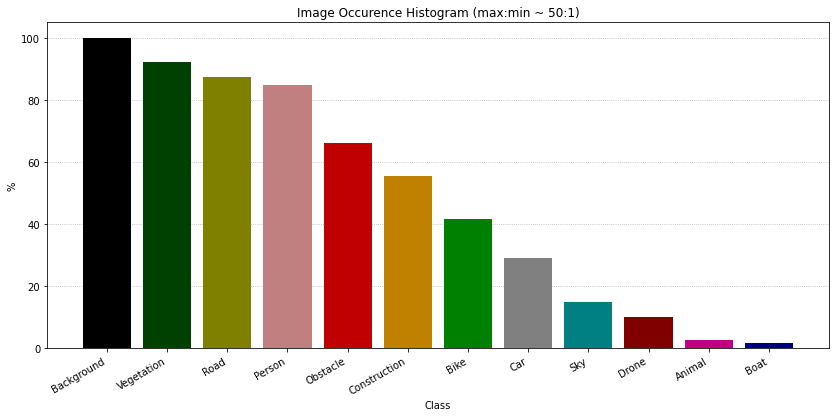

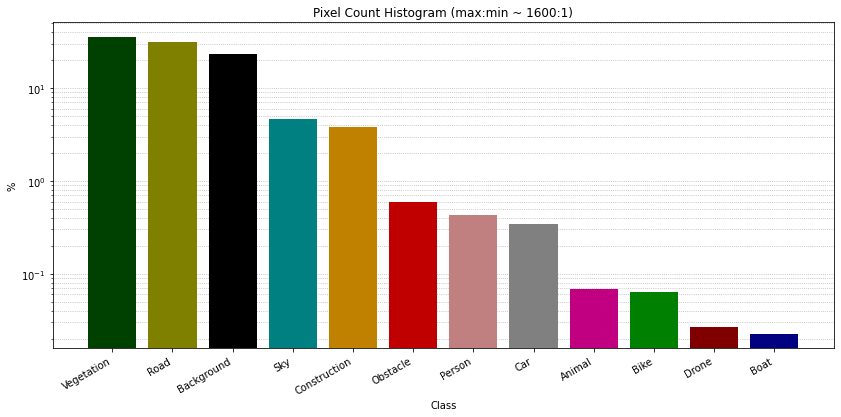

In [10]:
class ClassRepresentation(object):
    __pub_msk_csv_path = os.path.join(Data.data_dir, "train_mask.csv")

    @classmethod
    def get_mask_pxl_counts(cls):
        header = ("ImageID",) + Data.classes
        image_dict_list = Data.instance.get_pub_image_dict_list()
        image_dict_list = sorted(image_dict_list, key = lambda d: d["id"])
        
        def process(image_dict, data):
            counts = data[1:]
            assert image_dict["name"] == data[0]
            image_dict["mask_pixel_counts"] = counts
            return counts
        
        def analyze(image_dict):
            mask = cv2.imread(image_dict["mask_path"], 0)
            classes, counts = np.unique(mask, return_counts=True)
            d = {cls: count for cls, count in zip(classes, counts)}
            counts = [d.get(k, 0) for k in range(Data.num_classes)]
            image_dict["mask_pixel_counts"] = counts
            return [image_dict["name"]] + counts

        # if pixel counts are saved, then load them from the csv file
        if os.path.isfile(ClassRepresentation.__pub_msk_csv_path):
            df = pd.read_csv(ClassRepresentation.__pub_msk_csv_path, usecols=header, dtype={'ImageID': str})
            return [process(d, list(r)) for d, r in zip(image_dict_list, df.values)]
        
        # otherwise, compute pixel counts
        pbar = tqdm(image_dict_list, desc="Processing", unit="mask")
        analysis = [analyze(d) for d in pbar]
        pbar.close()
        
        # and save them to a csv file
        df = pd.DataFrame(analysis)
        df.to_csv(ClassRepresentation.__pub_msk_csv_path, index=False, header=("ImageID",)+Data.classes)
        return [counts[1:] for counts in analysis]

    @classmethod
    def compute_class_counts(cls):
        pub_mask_pxl_counts = cls.get_mask_pxl_counts()
        num_classes = Data.num_classes
        image_totals = np.array([0] * num_classes)
        pixel_totals = np.array([0] * num_classes)
        for counts in pub_mask_pxl_counts:
            image_totals += np.array([int(np.sign(count)) for count in counts])
            pixel_totals += np.array(counts)
        return image_totals, pixel_totals

    @classmethod
    def _plot_class_counts(cls, counts, divisor, title, yscale, ratio_approx):
        classes = Data.classes
        centers = range(Data.num_classes)
        counts = (np.array(counts) * 100 / divisor).tolist()
        colors = (np.array(Visualizer.class_colors) / 255).tolist()

        data = list(zip(classes, counts, colors))
        data.sort(key=lambda tup: tup[1], reverse=True)
        classes, counts, colors = zip(*data)

        ratio = int(np.max(counts) / np.min(counts) + 0.5)
        ratio = int(ratio / ratio_approx + 0.5) * ratio_approx
        
        fig = plt.figure(figsize=(14, 6))
        plt.title(f"{title} (max:min ~ {ratio}:1)")
        plt.bar(centers, counts, align="center", tick_label=classes, color=colors)
        plt.xticks(rotation=30, ha="right")
        plt.xlabel("Class")
        plt.yscale(yscale)
        plt.ylabel("%")
        plt.grid(True, which="both", axis="y", linestyle=':')
        plt.gca().set_axisbelow(True)
        plt.tight_layout
        plt.show()
        
    @classmethod
    def plot_image_histogram(cls, counts):
        divisor = Data.instance.pub_image_dict_len
        cls._plot_class_counts(counts, divisor, "Image Occurence Histogram", "linear", 10)

    @classmethod
    def plot_pixel_histogram(cls, counts):
        divisor = np.sum(counts)
        cls._plot_class_counts(counts, divisor, "Pixel Count Histogram", "log", 100)

        
image_counts, pixel_counts = ClassRepresentation.compute_class_counts()
ClassRepresentation.plot_image_histogram(image_counts)
ClassRepresentation.plot_pixel_histogram(pixel_counts)

## <font style="color:orange">Class Exploration</font>

Given this dataset's significant class imbalance, mitigating techniques will likely need to be employed. The `get_images_containing(cls_name)` function returns image dictionary list of image/mask pairs that contain the specified class.

Boat Samples


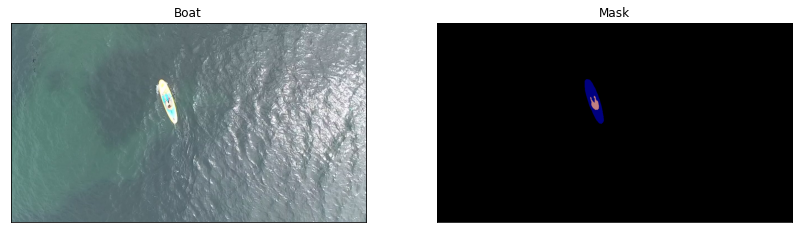

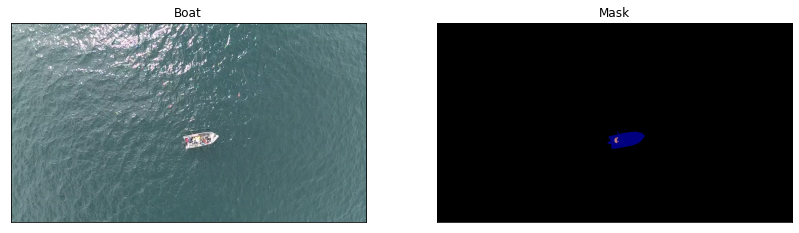

In [11]:
def get_images_containing(cls_name):
    cls_idx = Data.class_index(cls_name)
    img_dict_list = Data.instance.get_pub_image_dict_list()
    img_dict_list = [img_dict for img_dict in img_dict_list if img_dict["mask_pixel_counts"][cls_idx] > 0]
    img_dict_list.sort(key=lambda img_dict: img_dict["mask_pixel_counts"][cls_idx], reverse=True)
    return img_dict_list


print(f"Boat Samples")
boat_dict_list = get_images_containing("Boat")
random.shuffle(boat_dict_list)
for image_dict in boat_dict_list[:2]:
    Visualizer.visualize_images(boat=image_dict["image_path"], mask=image_dict["mask_path"])

## <font style="color:orange">Data Synthesis</font>

Implementing data synthesis based on a slight variant of the technique described in [Simple Copy-Paste is a Strong Data Augmentation Method for Instance Segmentation](https://arxiv.org/pdf/2012.07177v1.pdf).

In [12]:
def copy_and_paste(image_copy, mask_copy, image_paste, mask_paste, class_values):
    from scipy import ndimage

    height, width = mask_copy.shape
    alpha = np.isin(mask_copy, class_values)
    mask_comp = (mask_copy * alpha) + (mask_paste * np.logical_not(alpha))
    
    alpha = ndimage.gaussian_filter(alpha.astype(float), sigma=1., mode="nearest")
    alpha = np.repeat(alpha, 3, axis=1).reshape((height, width, 3))
    image_comp = np.uint8(np.clip(alpha * image_copy + (1. - alpha) * image_paste + 0.5, 0, 255))

    return image_comp, mask_comp

First copy and Paste Test


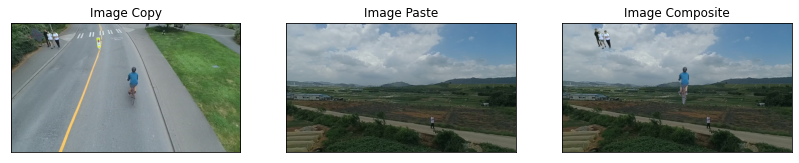

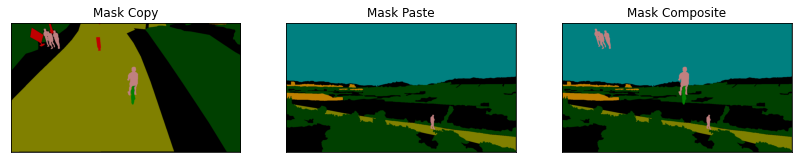

Second copy and Paste Test


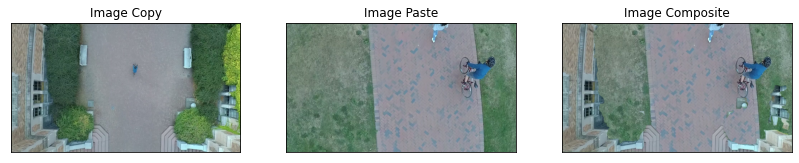

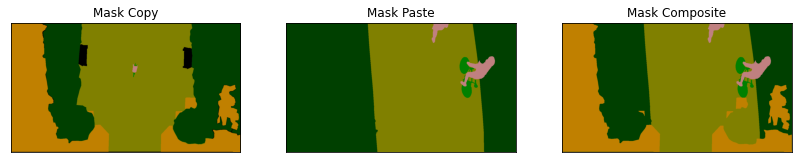

In [13]:
def load_from_cache(idx):
    image_cache = ImageCache.instance
    return image_cache.image(idx), image_cache.mask(idx)

def test_copy_and_paste(idx1, idx2, class_values):
    image_paste, mask_paste = load_from_cache(idx1)
    image_copy , mask_copy  = load_from_cache(idx2)

    image_comp, mask_comp = copy_and_paste(image_copy, mask_copy, image_paste, mask_paste, class_values)
    Visualizer.visualize_images(image_copy=image_copy, image_paste=image_paste, image_composite=image_comp)
    Visualizer.visualize_images(mask_copy=mask_copy, mask_paste=mask_paste, mask_composite=mask_comp)

print("First copy and Paste Test")
test_copy_and_paste(1594, 2559, Data.class_values(["Person", "Bike"]))
print("Second copy and Paste Test")
test_copy_and_paste(0, 1, Data.class_values(["Construction"]))

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

## <font style="color:orange">Evaluation Metrics</font>

The `IouAndDiceMetrics` class computes the _mean_ and _per class_ IoU and Dice coefficients using tensor operations. Given a batch of the predicted and ground truth masks are already loaded on the GPU for the loss calculation, the computation of the IoU and Dice coefficients on the GPU is very efficient. While these _per class_ coefficients are computed for batch of predicted/ground truth pairs, they are computed for each pair to honor the special case where the coefficient is unity when $X$ and $Y$ are empty.

Since both IoU and Dice coefficients can be computed from the intersection $(|X \cap Y|)$ between, and cardinality $(|X| + |Y|)$ of, the predictions and ground truths, it is more efficient to compute them simultaneously rather than separately. 

$$|X \cup Y| = |X| + |Y| - |X \cap Y|$$

$$Dice = \frac{2 |X \cap Y| + \epsilon}{|X| + |Y| + \epsilon}$$

$$IoU = \frac{|X \cap Y| + \epsilon}{|X \cup Y| + \epsilon} = \frac{|X \cap Y| + \epsilon}{|X| + |Y| - |X \cap Y| + \epsilon}$$

In [14]:
class IouAndDiceMetrics(object):
    # ToDo: If needed, add ignore classes to constructor.
    def __init__(self, num_classes, image_width=1280, image_height=720, eps=1e-7):
        self._eps = eps
        self._num_classes = num_classes
        self._image_width = image_width
        self._image_height = image_height
        self.reset()
        
    def reset(self):
        self._n = 0
        self._iou_totals = np.array([0.] * self._num_classes)
        self._dice_totals = np.array([0.] * self._num_classes)
        
    def add(self, y_pred, y_true):
        from torch.nn import functional as f
        batch_size, num_classes, image_height, image_width = tuple(y_true.shape)
        
        # remove padding so it does impact metrics
        if (image_height == 736):
            y_pred = y_pred.narrow(2, 8, self._image_height)
            y_true = y_true.narrow(2, 8, self._image_height)
                
        # flatten height and width and one-hot encode prediction
        y_pred = y_pred.view(batch_size, num_classes, -1)
        y_true = y_true.view(batch_size, num_classes, -1)
        y_pred = f.one_hot(y_pred.argmax(dim=1), num_classes).transpose(1, 2).type_as(y_true)
        
        # compute the intersection (|y_pred * y_true|) and cardinality (|y_pred| + |y_true|)
        cardinality = torch.sum(y_pred + y_true, dim=2)
        intersection = torch.sum(y_pred * y_true, dim=2)
        
        # compute "per class" IoU and Dice coefficients for each prediction and sum over batch
        iou = torch.sum((intersection + self._eps) / (cardinality - intersection + self._eps), dim=0)
        dice = torch.sum((2. * intersection + self._eps) / (cardinality + self._eps), dim=0)
        
        # update the count and totals
        self._n += batch_size
        self._iou_totals += iou.data.cpu().numpy()
        self._dice_totals += dice.data.cpu().numpy()
        
    @property
    def iou(self):
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = self._iou_totals / self._n
            return np.nanmean(iou), iou
        
    @property
    def dice(self):
        with np.errstate(divide='ignore', invalid='ignore'):
            dice = self._dice_totals / self._n
            return np.nanmean(dice), dice

# <font style="color:orange">Framework</font>

Several classes were developed to experiment with different models. These classes are good candidates to move into the custom tools module.

In [15]:
from segmentation_models_pytorch import DeepLabV3Plus, FPN, Linknet
from segmentation_models_pytorch.encoders import get_preprocessing_fn

## <font style="color:orange">Utility Classes</font>

Instances of the `FixedLengthIterator` class wrap another iterator, e.g., a data loader, to provide an iterator of a specified length. If necessary, the wrappered iterator will cycle and repeat itself.

Instances of the `SimpleStatistics` class allow values to be added and perform simple statistics, e.g., minimum, maximum, mean, exponential moving average, etc.

In [16]:
class FixedLengthIterator(object):
    def __init__(self, it, length):
        import itertools
        self._it = itertools.cycle(it)
        self._length = length

    def __len__(self):
        return self._length

    def __iter__(self):
        self._index = 0
        return self

    def __next__(self):
        self._index += 1
        if self._index > self._length:
            raise StopIteration()
        return next(self._it)


class SimpleStatistics(object):
    def __init__(self, alpha=0.3):
        self._alpha = 0.3
        self.reset()

    def reset(self):
        self._n = 0
        self._ema = 0.
        self._total = 0.
        self._values = []

    @property
    def samples(self):
        return self._n

    @property
    def first(self):
        return self._values[0] if self._n > 0 else float("nan")

    @property
    def last(self):
        return self._values[-1] if self._n > 0 else float("nan")

    @property
    def min(self):
        return min(self._values) if self._n > 0 else float("nan")

    @property
    def max(self):
        return max(self._values) if self._n > 0 else float("nan")

    @property
    def mean(self):
        return self._total / self._n if self._n > 0 else float("nan")

    @property
    def ema(self):
        return self._ema if self._n > 0 else float("nan")

    @property
    def values(self):
        return self._values

    def add(self, x):
        beta = 1. - self._alpha
        self._total += x
        self._values.append(x)
        self._ema = self._alpha * x + (1 - self._alpha) * self._ema if self._n > 0 else x
        self._n += 1
        return self.mean

## <font style="color:orange">Configuration</font>

Instances of the `Config` class store experiment specific details, e.g., which model and encoder to use, which dataset split to use, which transformations to use during training and validation, learning rates, number of epochs, whether to anneal the best model when the trainer is finished or loses patience, etc.

In [17]:
class Config(dict):
    def __init__(self, d=None):
        if isinstance(d, dict):
            self.merge(d)
        elif not None:
            raise ValueError("Parameter d must be None or a dictionary.")
    
    def merge(self, d):
        for k, v in d.items():
            if not isinstance(v, dict):
                self[k] = v
            else:
                if k not in self:
                    self[k] = Config(v)
                else:
                    if not isinstance(self[k], dict):
                        raise ValueError(f"Cannot merge dictionary {k} with a non-dictionary value.")
                    self[k].merge(v)
    
    def __getattr__(self, name):
        if name in self:
            return self[name]
        raise AttributeError(name)

    def __setattr__(self, name, value):
        self[name] = value

    def __str__(self):
        def _enumerate(d, prefix=""):
            output = []
            for k, v in d.items():
                if isinstance(v, dict):
                    output.extend(_enumerate(v, prefix + k + '.'))
                else:
                    output.append(f"{prefix + k}: {v}")
            return output
        return '\n'.join(_enumerate(self))

    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, super(CfgNode, self).__repr__())

    @classmethod
    def from_dict(cls, d):
        return Config(d)
    
    @classmethod
    def from_yaml(cls, s):
        return Config(cls.__cleanup_yaml(yaml.safe_load(s)))
        
    @classmethod
    def __cleanup_yaml(cls, d):
        for k, v in d.items():
            if isinstance(v, dict):
                cls.__cleanup_yaml(v)
            elif isinstance(v, str):
                if v.lower() == "none":
                    d[k] = None
                elif v.startswith('('):
                    try:
                        d[k] = eval(v)
                    except Exception:
                        pass
        return d
        
    @classmethod
    def default(cls):
        return cls.from_yaml(cls.__default)
        
    __default = """
        EXPERIMENT:
          PREFIX: "PREFIX"
          SUFFIX: "SUFFIX"
          LOAD_PREV: None
        MODEL:
          NAME: "FPN"
          ABBR: "FPN"
          ENCODER: 
            NAME: "efficientnet-b3"
            ABBR: "EFF3"
            WEIGHTS: "imagenet"
          ACTIVATION: None
        DATASETS:
          SPLIT_INDEX: 0
          CLASSES: "all"
          AUGMENTATION:
            HORIZONTAL_FLIP:
              ENABLE: False
              PROBABILITY: 0.5
            SHIFT_SCALE_ROTATE:
              ENABLE: False
              PROBABILITY: 0.5
              SHIFT_LIMIT: 0.0625
              SCALE_LIMIT: 0.1
              ROTATE_LIMIT: 10
            TILE:
              ENABLE: False
              WIDTH: 416
              HEIGHT: 224
              SETS: [[1280, 720, 4, 4], [640, 360, 2, 2]]
            COPY_PASTE:
                ENABLE: False
                PROBABILITY: 0.667
                MAX_REL_AREA: 0.5
                MAX_CLASSES: 3
                CLASSES: "all"
                VARIANT: "random"
                DELAY: 1
            COLOR:
              ENABLE: False
              PROBABILITY: 0.9
              CLAHE:
                ENABLE: True
                PROBABILITY: 1.0
                CLIP_LIMIT: 4.0
              BRIGHTNESS_CONTRAST:
                ENABLE: True
                PROBABILITY: 1.0
                BRIGHTNESS_LIMIT: 0.2
                CONTRAST_LIMIT: 0.2
                BRIGHTNESS_BY_MAX: True
              HUE_SATURATION_VALUE:
                ENABLE: True
                PROBABILITY: 1.0
                HUE_SHIFT_LIMIT: 20
                SAT_SHIFT_LIMIT: 30
                VAL_SHIFT_LIMIT: 20
            GAUSSIAN_NOISE:
                ENABLE: False
                PROBABILITY: 0.2
                VAR_LIMIT: (10.0, 50.0)
                MEAN: 0.0
        DATALOADERS:
          TRAIN:
            BATCH_SIZE: 2
            NUM_WORKERS: 8
            SHUFFLE: True
            PIN_MEMORY: True
            DROP_LAST: True
          COPY_PASTE:
            BATCH_SIZE: 1
            NUM_WORKERS: 8
            SHUFFLE: True
            PIN_MEMORY: False
            DROP_LAST: False
          VALID:
            BATCH_SIZE: 4
            NUM_WORKERS: 8
            SHUFFLE: False
            PIN_MEMORY: True
            DROP_LAST: False
          VISUALIZE:
            BATCH_SIZE: 8
            NUM_WORKERS: 8
            SHUFFLE: True
            PIN_MEMORY: FALSE
            DROP_LAST: True
        LOSS_FN:
            WEIGHTS: None
            ADAPTIVE:
                ENABLE: False
                MAX_WEIGHT: 3.0
        SOLVER:
          MAX_LR: 1.0e-3
          MIN_LR: 1.0e-8
          PATIENCE: 5
          NUM_EPOCHS: 100
          ANN_EPOCHS: 4
        """

## <font style="color:orange">Experiment Data</font>

Instances of the `ExpData` class creates training (train), validation (valid), and test (test) image dictionary lists, datasets, and data loaders. Datasets and data loaders may return results ready to be consumed by the network (net) or visualized (viz). In addition, this class creates geometric, tiling, and pixel level transforms.

In [18]:
class ExpData(object):
    def __init__(self, cfg):
        self._seed, _ = Data.split_params(cfg.DATASETS.SPLIT_INDEX)
        tools.utils.seed_system(self._seed)
        self._cfg = cfg
        self._test_net_loader = None
        self._test_viz_loader = None
        self._test_net_dataset = None
        self._test_viz_dataset = None
        self._valid_net_loader = None
        self._valid_viz_loader = None
        self._valid_net_dataset = None
        self._valid_viz_dataset = None
        self._train_net_loader = None
        self._train_viz_loader = None
        self._train_net_dataset = None
        self._train_viz_dataset = None
        self._train_copy_paste_dataset = None
        self._train_copy_paste_loader = None
        self._train_idx, self._valid_idx = Data.instance.split_pub_dataset(cfg.DATASETS.SPLIT_INDEX)
        self._test_image_dict_list = Data.instance.get_prv_image_dict_list()
        self._valid_image_dict_list = Data.instance.get_pub_image_dict_list(self._valid_idx)
        self._train_image_dict_list = Data.instance.get_pub_image_dict_list(self._train_idx)
        self._encoder_preprocessing_fn = get_preprocessing_fn(cfg.MODEL.ENCODER.NAME, cfg.MODEL.ENCODER.WEIGHTS)
        self._classes = cfg.DATASETS.CLASSES
        if self._classes == "all":
            self._classes = Data.classes

    @property
    def test_image_dict_list(self):
        return self._test_image_dict_list
    
    @property
    def valid_image_dict_list(self):
        return self._valid_image_dict_list
    
    @property
    def train_image_dict_list(self):
        return self._train_image_dict_list
    
    @property
    def test_net_dataset(self):
        if self._test_net_dataset is None:
            self._test_net_dataset = ExpData._create_dataset(
                image_dict_list = self._test_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = self._encoder_preprocessing_fn,
                use_image_cache = False
            )
        return self._test_net_dataset
    
    @property
    def test_viz_dataset(self):
        if self._test_viz_dataset is None:
            self._test_viz_dataset = ExpData._create_dataset(
                image_dict_list = self._test_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = None,
                use_image_cache = False
            )
        return self._test_viz_dataset

    @property
    def valid_net_dataset(self):
        if self._valid_net_dataset is None:
            self._valid_net_dataset = ExpData._create_dataset(
                image_dict_list = self._valid_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = self._encoder_preprocessing_fn,
                use_image_cache = not self._cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE
            )
        return self._valid_net_dataset
    
    @property
    def valid_viz_dataset(self):
        if self._valid_viz_dataset is None:
            self._valid_viz_dataset = ExpData._create_dataset(
                image_dict_list = self._valid_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = None,
                use_image_cache = not self._cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE
            )
        return self._valid_viz_dataset

    @property
    def train_net_dataset(self):
        if self._train_net_dataset is None:
            self._train_net_dataset = ExpData._create_dataset(
                image_dict_list = self._train_image_dict_list, 
                classes = self._classes, 
                augmentation = self._cfg.DATASETS.AUGMENTATION, 
                encoder_preprocessing_fn = self._encoder_preprocessing_fn,
                use_image_cache = True
            )
        return self._train_net_dataset
    
    @property
    def train_viz_dataset(self):
        if self._train_viz_dataset is None:
            self._train_viz_dataset = ExpData._create_dataset(
                image_dict_list = self._train_image_dict_list, 
                classes = self._classes, 
                augmentation = self._cfg.DATASETS.AUGMENTATION, 
                encoder_preprocessing_fn = None,
                use_image_cache = True
            )
        return self._train_viz_dataset

    @property
    def train_copy_paste_dataset(self):
        if self._train_copy_paste_dataset is None:
            self._train_copy_paste_dataset = ExpData._create_copy_and_paste_dataset(
                image_dict_list = self._train_image_dict_list, 
                augmentation = self._cfg.DATASETS.AUGMENTATION, 
            )
        return self._train_copy_paste_dataset

    @property
    def test_net_loader(self):
        if self._test_net_loader is None:
            self._test_net_loader = ExpData._create_loader(
                dataset = self.test_net_dataset, 
                params = self._cfg.DATALOADERS.VALID
            )
        return self._test_net_loader

    @property
    def test_viz_loader(self):
        if self._test_viz_loader is None:
            self._test_viz_loader = ExpData._create_loader(
                dataset = self.test_viz_dataset, 
                params = self._cfg.DATALOADERS.VISUALIZE
            )
        return self._test_viz_loader
    
    @property
    def valid_net_loader(self):
        if self._valid_net_loader is None:
            self._valid_net_loader = ExpData._create_loader(
                dataset = self.valid_net_dataset, 
                params = self._cfg.DATALOADERS.VALID
            )
        return self._valid_net_loader

    @property
    def valid_viz_loader(self):
        if self._valid_viz_loader is None:
            self._valid_viz_loader = ExpData._create_loader(
                dataset = self.valid_viz_dataset, 
                params = self._cfg.DATALOADERS.VISUALIZE
            )
        return self._valid_viz_loader

    @property
    def train_net_loader(self):
        if self._train_net_loader is None:
            self._train_net_loader = ExpData._create_loader(
                dataset = self.train_net_dataset, 
                params = self._cfg.DATALOADERS.TRAIN
            )
        return self._train_net_loader

    @property
    def train_viz_loader(self):
        if self._train_viz_loader is None:
            self._train_viz_loader = ExpData._create_loader(
                dataset = self.train_viz_dataset, 
                params = self._cfg.DATALOADERS.VISUALIZE
            )
        return self._train_viz_loader

    @property
    def train_copy_paste_loader(self):
        if self._train_copy_paste_loader is None:
            self._train_copy_paste_loader = ExpData._create_loader(
                dataset = self.train_copy_paste_dataset,
                params = self._cfg.DATALOADERS.COPY_PASTE
            )
        return self._train_copy_paste_loader

    @classmethod
    def _create_dataset(cls, image_dict_list, classes, augmentation, encoder_preprocessing_fn, use_image_cache):
        geometric_transforms = None
        if augmentation is None or not augmentation.COPY_PASTE.ENABLE:
            geometric_transforms = cls.create_geometric_transforms(augmentation)
        tile_transforms_list = cls.create_tile_transforms_list(augmentation)
        pixel_transforms = cls.create_pixel_transforms(augmentation)
        final_transforms = cls.create_final_transforms(augmentation, encoder_preprocessing_fn)
        return Dataset(
            image_dict_list,
            classes = classes,
            pixel_transforms = pixel_transforms,
            final_transforms = final_transforms,
            geometric_transforms = geometric_transforms,
            tile_transforms_list = tile_transforms_list,
            binary_masks = encoder_preprocessing_fn is not None,
            use_image_cache = use_image_cache
        )

    @classmethod
    def _create_copy_and_paste_dataset(cls, image_dict_list, augmentation):
        return CopyPasteDataset(
            image_dict_list,
            geometric_transforms = cls.create_geometric_transforms(augmentation)
        )

    @classmethod
    def _create_loader(cls, dataset, params):
        return DataLoader(
            dataset = dataset, 
            batch_size = params.BATCH_SIZE,
            shuffle = params.SHUFFLE,
            num_workers = params.NUM_WORKERS,
            pin_memory = params.PIN_MEMORY,
            drop_last = params.DROP_LAST
        )

    @classmethod
    def create_geometric_transforms(cls, augmentation=None):
        import albumentations as albu
        geometric_transforms = []
        if augmentation:
            if augmentation.HORIZONTAL_FLIP.ENABLE:
                geometric_transforms.append(albu.HorizontalFlip(p=augmentation.HORIZONTAL_FLIP.PROBABILITY))           
            if augmentation.SHIFT_SCALE_ROTATE.ENABLE:
                geometric_transforms.append(albu.ShiftScaleRotate(
                    shift_limit = augmentation.SHIFT_SCALE_ROTATE.SHIFT_LIMIT,
                    scale_limit = augmentation.SHIFT_SCALE_ROTATE.SCALE_LIMIT,
                    rotate_limit = augmentation.SHIFT_SCALE_ROTATE.ROTATE_LIMIT,
                    p = augmentation.SHIFT_SCALE_ROTATE.PROBABILITY
                ))
        return albu.Compose(geometric_transforms) if len(geometric_transforms) > 0 else None

    @classmethod
    def create_tile_transforms_list(cls, augmentation=None):
        import albumentations as albu
        tile_transforms_list = []
        if augmentation and augmentation.TILE.ENABLE:
            tile_width = augmentation.TILE.WIDTH
            tile_height = augmentation.TILE.HEIGHT
            for image_width, image_height, cols, rows in augmentation.TILE.SETS:
                for row in range(rows):
                    y_min = row * (image_height - tile_height) // (rows - 1)
                    y_max = y_min + tile_height # - 1
                    for col in range(cols):
                        x_min = col * (image_width - tile_width) // (cols - 1)
                        x_max = x_min + tile_width # - 1
                        tile_transforms = []
                        if image_width != 1280 or image_height != 720:
                            tile_transforms.append(albu.Resize(
                                height = image_height,
                                width = image_width,
                                always_apply = True
                            ))
                        tile_transforms.append(albu.Crop(
                            x_min = x_min,
                            y_min = y_min,
                            x_max = x_max,
                            y_max = y_max,
                            always_apply = True
                        ))
                        tile_transforms_list.append(albu.Compose(tile_transforms))
        return tile_transforms_list if len(tile_transforms_list) > 0 else None

    @classmethod
    def create_pixel_transforms(cls, augmentation=None):
        import albumentations as albu
        
        def transpose(x, **kwargs):
            return x.transpose(2, 0, 1).astype('float32')    
        
        pixel_transforms = []

        if augmentation and augmentation.COLOR.ENABLE:
            color_transforms = []
            
            if augmentation.COLOR.CLAHE.ENABLE:
                color_transforms.append(albu.CLAHE(
                    clip_limit = augmentation.COLOR.CLAHE.CLIP_LIMIT,
                    p = augmentation.COLOR.CLAHE.PROBABILITY
                ))

            if augmentation.COLOR.BRIGHTNESS_CONTRAST.ENABLE:
                color_transforms.append(albu.RandomBrightnessContrast(
                    brightness_limit = augmentation.COLOR.BRIGHTNESS_CONTRAST.BRIGHTNESS_LIMIT,
                    contrast_limit = augmentation.COLOR.BRIGHTNESS_CONTRAST.CONTRAST_LIMIT,
                    brightness_by_max = augmentation.COLOR.BRIGHTNESS_CONTRAST.BRIGHTNESS_BY_MAX,
                    p = augmentation.COLOR.BRIGHTNESS_CONTRAST.PROBABILITY
                ))

            if augmentation.COLOR.HUE_SATURATION_VALUE.ENABLE:
                color_transforms.append(albu.HueSaturationValue(
                    hue_shift_limit = augmentation.COLOR.HUE_SATURATION_VALUE.HUE_SHIFT_LIMIT,
                    sat_shift_limit = augmentation.COLOR.HUE_SATURATION_VALUE.SAT_SHIFT_LIMIT,
                    val_shift_limit = augmentation.COLOR.HUE_SATURATION_VALUE.VAL_SHIFT_LIMIT,
                    p = augmentation.COLOR.HUE_SATURATION_VALUE.PROBABILITY
                ))

            if len(color_transforms) > 0:
                pixel_transforms.append(albu.OneOf(color_transforms, p=augmentation.COLOR.PROBABILITY))
            
        if augmentation and augmentation.GAUSSIAN_NOISE.ENABLE:
            pixel_transforms.append(albu.GaussNoise(
                var_limit = augmentation.GAUSSIAN_NOISE.VAR_LIMIT,
                mean = augmentation.GAUSSIAN_NOISE.MEAN,
                p = augmentation.GAUSSIAN_NOISE.PROBABILITY
            ))
        
        return albu.Compose(pixel_transforms) if len(pixel_transforms) > 0 else None

    @classmethod
    def create_final_transforms(cls, augmentation=None, encoder_preprocessing_fn=None):
        import albumentations as albu
        
        def transpose(x, **kwargs):
            return x.transpose(2, 0, 1).astype('float32')    
        
        final_transforms = []

        # !!! image and mask dimensions must be divisible by 32 !!!
        if augmentation is None or not augmentation.TILE.ENABLE:
            final_transforms.append(albu.PadIfNeeded(min_height=736, min_width=1280, always_apply=True))
            
        if encoder_preprocessing_fn:
            final_transforms.append(albu.Lambda(image=encoder_preprocessing_fn, name="encoder_preprocessing_fn"))
            final_transforms.append(albu.Lambda(image=transpose, mask=transpose, name="transpose"))
            
        return albu.Compose(final_transforms) if len(final_transforms) > 0 else None        

## <font style="color:orange">Inferencer</font>

Instances of the `Inferencer` class load a trained model and predict the mask(s) of a specified image(s). The `predict` method accepts image dictionary, numpy, and tensor arguments and my optionally perform an activation on the resulting prediction.

In [19]:
class Inferencer(ExpData):
    _output_dir = "./output"
    _best_model = "best_model.pth"
    _last_model = "last_model.pth"

    def __init__(self, cfg):
        super().__init__(cfg)
        self._model = None
        self._name = Inferencer.name(cfg)
        self._output_dir = Inferencer.output_dir(cfg)
        os.makedirs(self._output_dir, exist_ok=True)
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._init_continued(cfg)
    
    def _init_continued(self, cfg):
        path = os.path.join(self._output_dir, Inferencer._best_model)
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint["model_state_dict"])

    @classmethod
    def name(cls, cfg):
        return f"{cfg.EXPERIMENT.PREFIX}-{cfg.MODEL.ABBR}-{cfg.MODEL.ENCODER.ABBR}-{cfg.EXPERIMENT.SUFFIX}"
        
    @classmethod
    def output_dir(cls, cfg):
        return os.path.join(cls._output_dir, cls.name(cfg))
        
    @property
    def device(self):
        return self._device
    
    @property
    def model(self):
        if self._model is None:
            self._model = self._create_model()
            self._model.to(self._device)
        return self._model
    
    def __get_image(self, image_dict, image_dict_list, dataset):
        try:
            idx = image_dict_list.index(image_dict)
            image, _ = dataset[idx]
            return image
        except ValueError:
            return None

    def predict(self, images, activation=None):       
        from torch.nn import functional as f

        # prepare input
        if isinstance(images, torch.Tensor):
            images = images.to(self.device)
        elif isinstance(images, np.ndarray):
            images = torch.from_numpy(images).to(self.device)
        elif isinstance(images, dict):
            image = self.__get_image(images, self.valid_image_dict_list, self.valid_net_dataset)
            if image is None:
                image = self.__get_image(images, self.test_image_dict_list, self.test_net_dataset)
                if image is None:
                    raise ValueError("unknown image dictionary")
            images = torch.from_numpy(image).to(self.device)
        else:
            raise ValueError("images must be a torch.Tensor, np.ndarray, or image dictionary")

        # add batch size of 1 if individual image
        squeeze = False
        dims = len(images.shape)
        if dims == 3:
            squeeze = True
            images = images.unsqueeze(0)
        elif dims < 3 or dims > 4:
            raise ValueError("images must have three color channels")
            
        # get prediction
        self.model.eval()
        with torch.no_grad():        
            probs = self.model(images)
        probs = probs.narrow(2, 8, 720)
        
        # apply activitation
        if activation is None:
            output = probs
        elif activation == "argmax":
            output = probs.argmax(dim=1).byte()
        elif activation == "softmax":
            output = f.softmax(probs, dim=1)
        elif activation == "one_hot":
            batch_size, num_classes, image_height, image_width = tuple(probs.shape)
            probs = probs.view(batch_size, num_classes, -1)
            output = f.one_hot(probs.argmax(dim=1), num_classes).transpose(1, 2).byte()
            output = output.view(batch_size, num_classes, image_height, image_width)
        else:
            raise ValueError("activation should be 'argmax', 'softmax', 'one_hot', or None")
        
        # prepare output
        if squeeze:
            output = output.squeeze(0)

        return output
        
    def _create_model(self):
        model_class = getattr(sys.modules[__name__], self._cfg.MODEL.NAME)
        return model_class(
            encoder_name = self._cfg.MODEL.ENCODER.NAME,
            encoder_weights = self._cfg.MODEL.ENCODER.WEIGHTS,
            classes = len(self._classes),
            activation = self._cfg.MODEL.ACTIVATION
        )
    
    @classmethod
    def _create_progress_loader(cls, description, data_loader):
        return tqdm(
            iterable = data_loader, 
            bar_format = "{l_bar}{bar}| {n_fmt:>4}/{total_fmt:4} [{elapsed}<{remaining}, {rate_fmt}{postfix}]", 
            desc = description, 
            mininterval = 1., 
            unit = "batch"
        )

## <font style="color:orange">Trainer</font>

Instances of the `Trainer` class load a pretrained encoder or previously trained model to fine tune the model on the Aeroscapes dataset.

In [20]:
class Trainer(Inferencer):
    _runs_dir = "./runs"

    def __init__(self, cfg):
        super().__init__(cfg)
        self._loss_fn = None
        self._optimizer = None
        self._scheduler = None
        self._runs_dir = os.path.join(Trainer._runs_dir, self._name)
        # Instantiating the model, optimizer, and LR scheduler may produce output.
        with io.capture_output():
            model = self.model
            optimizer = self.optimizer
            scheduler = self.scheduler

    def _init_continued(self, cfg):
        if cfg.EXPERIMENT.LOAD_PREV:
            with io.capture_output():
                path = os.path.join(Inferencer._output_dir, cfg.EXPERIMENT.LOAD_PREV, Inferencer._best_model)
                checkpoint = torch.load(path)
                self.model.load_state_dict(checkpoint["model_state_dict"])

    @property
    def loss_fn(self):
        if self._loss_fn is None:
            self._loss_fn = self._create_loss_fn()
        return self._loss_fn
    
    @property
    def optimizer(self):
        if self._optimizer is None:
            self._optimizer = self._create_optimizer()
        return self._optimizer
    
    @property
    def scheduler(self):
        if self._scheduler is None:
            self._scheduler = self._create_scheduler()
        return self._scheduler

    @classmethod
    def _compute_loss_fn_weights(cls, metrics, max_weight):
        _, scores = metrics.dice
        return [(1. - score) * (max_weight - 1.) + 1. for score in scores]
    
    @classmethod
    def _compute_copy_paste_weights(cls, metrics):
        _, scores = metrics.dice
        weights = 1. - scores
        weights = 100. * weights / (np.sum(weights) + 0.01)
        return [int(max(weight, 1.) + 0.5) for weight in weights]                   
    
    @classmethod
    def _synthesize_data(
        cls, 
        epoch_num, 
        copy_paste_loader,
        copy_paste_params,
        weights = None,
        show_progress = False
    ):
        if weights is None:
            weights = [1] * Data.num_classes

        included_class_values = list(range(Data.num_classes))
        if not isinstance(copy_paste_params.CLASSES, str) or copy_paste_params.CLASSES.lower() != "all":
            included_class_values = Data.class_values(copy_paste_params.CLASSES)

        loader_pbar = copy_paste_loader
        if show_progress:
            loader_pbar = cls._create_progress_loader(f"Copy-Paste {epoch_num:03d}", copy_paste_loader)

        prob = copy_paste_params.PROBABILITY
        copy_paste_loader.dataset.shuffle()
        count_thd = int(copy_paste_params.MAX_REL_AREA * 1280 * 720)
        for idx, image_copy, mask_copy, dict_paste, image_paste, mask_paste, pixel_counts in loader_pbar:
            idx = int(idx)
            image_copy = image_copy.squeeze().numpy()
            mask_copy = mask_copy.squeeze().numpy()
            mask_paste = mask_paste.squeeze().numpy()
            image_paste = image_paste.squeeze().numpy()
            pixel_counts = pixel_counts.squeeze().numpy()

            if (random.random() >= prob):
                # do not copy and paste classes
                image_comp, mask_comp = image_paste, mask_paste
            else:
                # generated a weighted list of choices
                class_value_choices = []
                for class_value, (pixel_count, weight) in enumerate(zip(pixel_counts, weights)):
                    if class_value in included_class_values and pixel_count > 0:
                        class_value_choices.extend([class_value] * weight)
                random.shuffle(class_value_choices)

                # select a random number of unique choices whose area does not exceed the count threshold
                count = 0
                class_values = []
                max_classes = random.randint(1, copy_paste_params.MAX_CLASSES)
                for class_value in class_value_choices:
                    pixel_count = pixel_counts[class_value]
                    if count + pixel_count <= count_thd and class_value not in class_values:
                        count += pixel_count
                        class_values.append(class_value)
                        if len(class_values) >= max_classes:
                            break

                # create the compose image and mask
                if len(class_values) == 0:
                    image_comp, mask_comp = image_paste, mask_paste
                else:
                    image_comp, mask_comp = copy_and_paste(image_copy, mask_copy, image_paste, mask_paste, class_values)

            ImageCache.instance.update(idx, image_comp, mask_comp)

        if show_progress:
            loader_pbar.close()

    @classmethod
    def _do_train_cycle(
        cls, 
        epoch_num, 
        model,
        device,
        loss_fn,
        optimizer,
        scheduler,
        data_loader,
        metrics = None, 
        loss_stats = None,
        show_progress = False,
        annealing = False
    ):
        cycle_pbar = data_loader
        if show_progress:
            action = "  Training" if not annealing else " Annealing"
            cycle_pbar = cls._create_progress_loader(f"{action} {epoch_num:03d}", data_loader)

        model.train()
        for images, gt_masks in cycle_pbar:
            optimizer.zero_grad()
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            pr_masks = model(images)
            loss = loss_fn(pr_masks, gt_masks)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            mean_loss = float("nan")
            if loss_stats:
                loss_stats.add(float(loss))
                mean_loss = loss_stats.mean

            mean_dice = float("nan")
            if metrics:
                metrics.add(pr_masks, gt_masks)
                mean_dice, _ = metrics.dice
                
            if show_progress:
                cycle_pbar.set_postfix_str(f"loss={loss_stats.mean:.5f}, dice={mean_dice:.5f}")

        if show_progress:
            cycle_pbar.close()

    @classmethod
    def _do_valid_cycle(
        cls, 
        epoch_num, 
        model,
        device,
        loss_fn,
        data_loader,
        metrics = None, 
        loss_stats = None,
        show_progress = False
    ):
        cycle_pbar = data_loader
        if show_progress:
            cycle_pbar = cls._create_progress_loader(f"Validating {epoch_num:03d}", data_loader)
            
        model.eval()
        for images, gt_masks in cycle_pbar:
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            with torch.no_grad():        
                pr_masks = model(images)
                loss = loss_fn(pr_masks, gt_masks)

            mean_loss = float("nan")
            if loss_stats:
                loss_stats.add(float(loss))
                mean_loss = loss_stats.mean
            
            mean_dice = float("nan")
            if metrics:
                metrics.add(pr_masks, gt_masks)
                mean_dice, _ = metrics.dice
            
            if show_progress:
                cycle_pbar.set_postfix_str(f"loss={loss_stats.mean:.5f}, dice={mean_dice:.5f}")
                
        if show_progress:
            cycle_pbar.close()
    
    def train(self):
        from torch.utils.tensorboard import SummaryWriter 
        tools.utils.seed_system(self._seed)

        def synthesize_data(epoch_num, metrics):
            copy_paste_params = self._cfg.DATASETS.AUGMENTATION.COPY_PASTE
            if copy_paste_params.ENABLE:
                weights = None
                if epoch_num > copy_paste_params.DELAY and copy_paste_params.VARIANT.lower() == "weighted":
                    weights = Trainer._compute_copy_paste_weights(metrics)
                Trainer._synthesize_data(
                    epoch_num = epoch_num, 
                    copy_paste_loader = self.train_copy_paste_loader,
                    copy_paste_params = copy_paste_params,
                    weights = weights,
                    show_progress = True
                )

        def update_loss_fn_weights(epoch_num, metrics):
            loss_fn_params = self._cfg.LOSS_FN
            if epoch_num > 1 and loss_fn_params.ADAPTIVE.ENABLE:
                weights = torch.tensor(Trainer._compute_loss_fn_weights(metrics, loss_fn_params.ADAPTIVE.MAX_WEIGHT))
                weights = len(weights) * weights / torch.sum(weights)
                self.loss_fn.weights = weights.to(self.device)
        
        def log_results(writer, epoch_num, metrics, loss_stats):
            mean_loss = loss_stats.mean
            mean_iou, per_class_iou = metrics.iou
            mean_dice, per_class_dice = metrics.dice
            writer.add_scalar("loss", mean_loss, epoch_num)
            writer.add_scalar("metrics/mean_iou", mean_iou, epoch_num)
            writer.add_scalar("metrics/mean_dice", mean_dice, epoch_num)
            for name, iou, dice in zip(self._classes, per_class_iou, per_class_dice):
                writer.add_scalar(f"iou/{name}", iou, epoch_num)
                writer.add_scalar(f"dice/{name}", dice, epoch_num)

        def do_train_cycle(writer, epoch_num, metrics, loss_stats, annealing):
            metrics.reset()
            loss_stats.reset()
            scheduler = self.scheduler if annealing else None
            Trainer._do_train_cycle(
                epoch_num = epoch_num,
                model = self.model, 
                device = self.device, 
                loss_fn = self.loss_fn, 
                optimizer = self.optimizer, 
                scheduler = scheduler, 
                data_loader = self.train_net_loader,
                metrics = metrics,
                loss_stats = loss_stats,
                show_progress = True,
                annealing = annealing
            )
            log_results(writer, epoch_num, metrics, loss_stats)
            writer.add_scalar("param/lr", self.optimizer.param_groups[0]['lr'], epoch_num)
            return True
        
        def do_valid_cycle(writer, epoch_num, metrics, loss_stats):
            metrics.reset()
            loss_stats.reset()
            Trainer._do_valid_cycle(
                epoch_num = epoch_num,
                model = self.model, 
                device = self.device, 
                loss_fn = self.loss_fn, 
                data_loader = self.valid_net_loader,
                metrics = metrics,
                loss_stats = loss_stats,
                show_progress = True
            )
            log_results(writer, epoch_num, metrics, loss_stats)
        
        def do_checkpoint(writer, loss, min_loss, epochs_since_best):
            if min_loss <= loss:
                epochs_since_best += 1
                self._save_checkpoint(epoch_num, False)
            else:
                min_loss = loss
                epochs_since_best = 0
                self._save_checkpoint(epoch_num, True)
            writer.add_scalar("param/epochs_since_best", epochs_since_best, epoch_num)
            return min_loss, epochs_since_best
        
        min_valid_loss = 1e10
        epochs_since_best = 0
        patience = self._cfg.SOLVER.PATIENCE
        
        train_writer = SummaryWriter(log_dir=os.path.join(self._runs_dir, "train"))
        train_metrics = IouAndDiceMetrics(len(self._classes))
        train_loss_stats = SimpleStatistics()
        
        valid_writer = SummaryWriter(log_dir=os.path.join(self._runs_dir, "valid"))
        valid_metrics = IouAndDiceMetrics(len(self._classes))
        valid_loss_stats = SimpleStatistics()
        
        valid_writer.add_scalar("param/epochs_since_best", 0, 0)
        train_writer.add_scalar("param/lr", self.optimizer.param_groups[0]['lr'], 0)
        
        do_valid_cycle(valid_writer, 0, valid_metrics, valid_loss_stats)
        for epoch_num in range(1, self._cfg.SOLVER.NUM_EPOCHS + 1):
            synthesize_data(epoch_num, valid_metrics)
            update_loss_fn_weights(epoch_num, valid_metrics)
            do_train_cycle(train_writer, epoch_num, train_metrics, train_loss_stats, annealing=False)
            do_valid_cycle(valid_writer, epoch_num, valid_metrics, valid_loss_stats)
            min_valid_loss, epochs_since_best = do_checkpoint(
                valid_writer, 
                valid_loss_stats.mean, 
                min_valid_loss, 
                epochs_since_best
            )
            if patience is not None and epochs_since_best >= patience:
                break
        
        epochs_since_best = 0
        with io.capture_output():
            best_epoch = self._load_checkpoint()
        
        epoch_ann = epoch_num + 1
        epoch_end = epoch_ann + self._cfg.SOLVER.ANN_EPOCHS
        for epoch_num in range(epoch_ann, epoch_end):
            synthesize_data(epoch_num, valid_metrics)
            update_loss_fn_weights(epoch_num, valid_metrics)
            do_train_cycle(train_writer, epoch_num, train_metrics, train_loss_stats, annealing=True)
            do_valid_cycle(valid_writer, epoch_num, valid_metrics, valid_loss_stats)
            min_valid_loss, epochs_since_best = do_checkpoint(
                valid_writer, 
                valid_loss_stats.mean, 
                min_valid_loss, 
                epochs_since_best
            )
    
        train_writer.close()
        valid_writer.close()
        self.model.eval()
    
    def _create_loss_fn(self):
        from tools.losses import DiceLoss
        weights = self._cfg.LOSS_FN.WEIGHTS
        if weights:
            weights = torch.tensor(weights)
            weights = len(weights) * weights / torch.sum(weights)
            weights = weights.to(self.device)
        return DiceLoss(mode="multiclass", weights=weights)
    
    def _create_optimizer(self):
        from tools.optimizers import Ranger
        # ToDo: Investigate whether specifying different LRs for model parameters is helpful.
        # learning_rate = 1e-3
        # [
        #     {'params': model.decoder.parameters(), 'lr': learning_rate}, 
        #     {'params': model.encoder.parameters(), 'lr': 1e-4},
        #     {'params': model.segmentation_head.parameters(), 'lr': learning_rate}
        # ]
        model = self.model
        return Ranger(model.parameters(), self._cfg.SOLVER.MAX_LR)
    
    def _create_scheduler(self):
        from torch.optim.lr_scheduler import CosineAnnealingLR
        return CosineAnnealingLR(
            optimizer = self.optimizer,
            T_max = self._cfg.SOLVER.ANN_EPOCHS * len(self.train_net_loader),
            eta_min = self._cfg.SOLVER.MIN_LR
        )
    
    def _load_checkpoint(self, path=None, best=True):
        if path is None:
            path = os.path.join(self._output_dir, Inferencer._best_model)
            if not best:
                path = os.path.join(self._output_dir, Inferencer._last_model)
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return checkpoint["epoch"]
    
    def _save_checkpoint(self, epoch, best=False):
        state = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict()
        }
        torch.save(state, os.path.join(self._output_dir, Inferencer._last_model))
        if best:
            torch.save(state, os.path.join(self._output_dir, Inferencer._best_model))

## <font style="color:orange">LR Sweep Test</font>

Instances of the `LrSweepTest` class perform and visualize a learning rate sweep as described by Leslie Smith in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf) and advocated by [Less Wright](https://github.com/lessw2020). It can also suggest an optimal learning rate; however, due to noise it is often better to select the learning rate by manually observing the resulting curve.

In [21]:
class LrSweepTest(object):
    def __init__(self, cfg, lrs=None, losses=None):
        self._cfg = cfg
        self._lrs = lrs
        self._losses = losses
        
    def run(self, start_lr=1e-7, end_lr=10, num_it=100):
        import math
        from torch.optim.lr_scheduler import LambdaLR

        trainer = Trainer(self._cfg)
        lr_ratio = start_lr / self._cfg.SOLVER.MIN_LR
        lr_exp_inc = lambda it: lr_ratio * (end_lr / start_lr) ** (it / (num_it - 1))
        optimizer = trainer.optimizer
        scheduler = LambdaLR(optimizer, lr_exp_inc)

        model = trainer.model
        device = trainer.device
        loss_fn = trainer.loss_fn
        train_net_loader = trainer.train_net_loader
        valid_net_loader = trainer.valid_net_loader

        self._lrs = []
        self._losses = []
        valid_loss_stats = SimpleStatistics()
        cycle_pbar = Trainer._create_progress_loader(f"LR Sweep", FixedLengthIterator(train_net_loader, num_it))
        for images, gt_masks in cycle_pbar:
            # perform a forward-backward pass
            model.train()
            lr = optimizer.param_groups[0]['lr']
            optimizer.zero_grad()
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            pr_masks = model(images)
            loss = loss_fn(pr_masks, gt_masks)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # compute mean validation loss
            valid_loss_stats.reset()
            Trainer._do_valid_cycle(0, model, device, loss_fn, valid_net_loader, None, valid_loss_stats, False)
        
            # can we stop prematurely?
            if math.isnan(valid_loss_stats.mean):
                break

            self._lrs.append(float(lr))
            self._losses.append(valid_loss_stats.mean)           
            cycle_pbar.set_postfix_str(f"lr={lr:.3e}, loss={valid_loss_stats.mean:.5f}")
                
        cycle_pbar.close()
    
    def _smooth_loss(self, alpha):       
        smooth = []
        loss_ema = self._losses[0]
        for loss in self._losses:
            loss_ema = alpha * loss + (1. - alpha) * loss_ema
            smooth.append(loss_ema)
        return smooth
    
    def load(self):
        import pandas as pd
        path = os.path.join(Inferencer.output_dir(self._cfg), "lr_sweep_test.csv")
        try:
            df = pd.read_csv(path, index_col=False)
            self._lrs = df["lrs"].tolist()
            self._losses = df["losses"].tolist()
            return true
        except:
            return false
        
    def save(self):
        output_dir = Inferencer.output_dir(self._cfg)
        path = os.path.join(output_dir, "lr_sweep_test.csv")
        os.makedirs(output_dir, exist_ok=True)
        df = pd.DataFrame({'lrs': self._lrs, 'losses': self._losses}) 
        df.to_csv(path, index=False) 
    
    def plot(self, alpha=0.3):
        if self._losses is None or len(self._losses) < 2:
            return
        fig = plt.figure(figsize=(8, 4))
        plt.title(f"LR Sweep Test")
        plt.xlabel("LR")
        plt.ylabel("Loss")
        plt.xscale("log")
        plt.plot(self._lrs, self._losses, color="#a0a0ff", label="raw")
        plt.plot(self._lrs, self._smooth_loss(alpha), color="#0000ff", label=f"ema (α = {alpha:.2f})")
        plt.legend()
        plt.grid(True, which="both", axis="x", linestyle=':')
        plt.grid(True, which="both", axis="y", linestyle=':')
        plt.gca().set_axisbelow(True)
        plt.tight_layout
        plt.show
        
    def suggestion(self, alpha=0.3):
        if self._losses is None or len(self._losses) < 10:
            return None, None
        lrs = torch.tensor(self._lrs[5:-5])
        losses = torch.tensor(self._smooth_loss(alpha)[5:-5])
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return lr_min, lr_steep

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

## <font style="color:orange">Model</font>

The model is specified in configuration file. The default configuration file uses `FPN` with an `EfficientNet-B3` encoder. The majority experiments used this model. Some experiments used DeepLab3+ and Linknet. One experiment used the timm-resnest50d encoder, another EfficientNet-B5. Other experiments used ResNet50 and SK-ResNe(X)t34. Learning rate (LR) sweep tests were performed to select the LR rate where the model learned fast.

In [22]:
# cannot recreate w/o code change
# ran on GeForce RTX 2080 Ti
def ExpAAA():
    cfg = Config.default()
    cfg.SOLVER.NUM_EPOCHS = 30
    cfg.EXPERIMENT.PREFIX = "AAA"
    cfg.EXPERIMENT.SUFFIX = "1C-FS-NA"
    cfg.DATASETS.SPLIT_INDEX = 0
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 2
    return cfg

# changed scheduler in code
# ran on GeForce RTX 2080 Ti
def ExpAAB():
    cfg = ExpAAA()
    cfg.SOLVER.NUM_EPOCHS = 100
    cfg.EXPERIMENT.PREFIX = "AAB"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-NA"
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpAAC():
    cfg = ExpAAB()
    cfg.EXPERIMENT.PREFIX = "AAC"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA"
    cfg.DATASETS.AUGMENTATION.HORIZONTAL_FLIP.ENABLE = True
    cfg.DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COLOR.ENABLE = True
    cfg.DATASETS.AUGMENTATION.GAUSSIAN_NOISE.ENABLE = True
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpAAD():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "AAD"
    cfg.EXPERIMENT.SUFFIX = "CA-T2-DA"
    cfg.DATASETS.AUGMENTATION.TILE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.TILE.WIDTH = 320
    cfg.DATASETS.AUGMENTATION.TILE.HEIGHT = 320
    cfg.DATASETS.AUGMENTATION.TILE.SETS = [[1280, 720, 6, 4], [854, 480, 4, 3], [640, 360, 3, 2]]
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 64
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpABA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "ABA"
    cfg.MODEL.ENCODER.NAME = "timm-resnest50d"
    cfg.MODEL.ENCODER.ABBR = "RNS50"
    cfg.MODEL.ENCODER.WEIGHTS: imagenet    
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 13
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpABB():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "ABB"
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 6
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpABC():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "ABC"
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 24
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpABD():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "ABD"
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.MODEL.ENCODER.NAME = "efficientnet-b5"
    cfg.MODEL.ENCODER.ABBR = "EFF5"
    cfg.MODEL.ENCODER.WEIGHTS = "imagenet"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 3
    cfg.DATALOADERS.VALID.BATCH_SIZE = 3
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpABE():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "ABE"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA"
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.MODEL.ENCODER.NAME = "resnet50"
    cfg.MODEL.ENCODER.ABBR = "RNT50"
    cfg.MODEL.ENCODER.WEIGHTS = "swsl"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 10
    cfg.DATALOADERS.VALID.BATCH_SIZE = 10
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpABF():
    cfg = ExpABE()
    cfg.EXPERIMENT.PREFIX = "ABF"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPW"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.DELAY = 5
    return cfg
    
# ran on Tesla V100-PCIE-32GB
def ExpABG():
    cfg = ExpABE()
    cfg.EXPERIMENT.PREFIX = "ABG"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CP5"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.CLASSES = ["Background", "Person", "Obstacle", "Construction", "Road"]
    return cfg 

# ran on Tesla V100-PCIE-32GB
def ExpABH():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "ABH"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA"
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.MODEL.ENCODER.NAME = "resnet152"
    cfg.MODEL.ENCODER.ABBR = "RNT152"
    cfg.MODEL.ENCODER.WEIGHTS = "imagenet"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 10
    cfg.DATALOADERS.VALID.BATCH_SIZE = 10
    return cfg

In [23]:
# ran on GeForce RTX 2080 Ti
def ExpBAA():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "BAA"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA"
    cfg.DATASETS.AUGMENTATION.TILE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.TILE.WIDTH = 640
    cfg.DATASETS.AUGMENTATION.TILE.HEIGHT = 352
    cfg.DATASETS.AUGMENTATION.TILE.SETS = [[1280, 720, 3, 3], [854, 480, 2, 2]]
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 10
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAB():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAB"
    cfg.DATASETS.SPLIT_INDEX = 1
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAC():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAC"
    cfg.DATASETS.SPLIT_INDEX = 2
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAD():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAD"
    cfg.DATASETS.SPLIT_INDEX = 3
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAE():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAE"
    cfg.DATASETS.SPLIT_INDEX = 4
    return cfg

 # ran on GeForce RTX 2080 Ti
def ExpBAF():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAF"
    cfg.DATASETS.SPLIT_INDEX = 5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAG():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAG"
    cfg.DATASETS.SPLIT_INDEX = 6
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAH():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAH"
    cfg.DATASETS.SPLIT_INDEX = 7
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAI():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAI"
    cfg.DATASETS.SPLIT_INDEX = 8
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBAJ():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BAJ"
    cfg.DATASETS.SPLIT_INDEX = 9
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBBA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "BBA"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAA-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBBB():
    cfg = ExpBAB()
    cfg.EXPERIMENT.PREFIX = "BBB"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAB-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBBC():
    cfg = ExpBAC()
    cfg.EXPERIMENT.PREFIX = "BBC"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAC-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBBD():
    cfg = ExpBAD()
    cfg.EXPERIMENT.PREFIX = "BBD"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAD-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpBBE():
    cfg = ExpBAE()
    cfg.EXPERIMENT.PREFIX = "BBE"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAE-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

In [24]:
# ran on Tesla V100-PCIE-32GB
def ExpCAA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "CAA"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA-W1"
    cfg.LOSS_FN.WEIGHTS = (3., 3., 3., 1., 1., 1., 1., 3., 3., 2., 2., 1.)
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 32
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpCAB():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "CAB"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA-W2"
    cfg.LOSS_FN.WEIGHTS = (10., 10., 10., 1., 1., 1., 1., 10., 10., 5., 5., 1.)
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpCAC():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "CAC"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA-W3"
    cfg.LOSS_FN.WEIGHTS = (1., 1., 1., 1., 1., 1., 1., 10., 1., 1., 1., 1.)
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 32
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpCAD():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "CAD"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA-W4"
    cfg.LOSS_FN.WEIGHTS = (1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.)
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 32
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpCAE():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "CAE"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA-W5"
    cfg.LOSS_FN.WEIGHTS = (2., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2., 1.)
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 32
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

In [25]:
# ran on GeForce RTX 2080 Ti
def ExpDAA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "DAA"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAA-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpDAB():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "DAB"
    cfg.EXPERIMENT.SUFFIX = "FT-FS-DA"
    cfg.EXPERIMENT.LOAD_PREV = "BAA-FPN-EFF3-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    cfg.DATASETS.AUGMENTATION.TILE.ENABLE = False
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 8
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpDAC():
    cfg = ExpDAB()
    cfg.EXPERIMENT.PREFIX = "DAC"
    cfg.EXPERIMENT.SUFFIX = "FT-FS-DA-W1"
    cfg.LOSS_FN.WEIGHTS = (3., 3., 3., 1., 1., 1., 1., 3., 3., 2., 2., 1.)
    cfg.SOLVER.MAX_LR = 5e-4
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpDAD():
    cfg = ExpDAB()
    cfg.EXPERIMENT.PREFIX = "DAD"
    cfg.EXPERIMENT.SUFFIX = "FT-FS-DA-W2"
    cfg.LOSS_FN.WEIGHTS = (10., 10., 10., 1., 1., 1., 1., 10., 10., 5., 5., 1.)
    cfg.SOLVER.MAX_LR = 5e-4
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpDAE():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "DAE"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA-W2"
    cfg.LOSS_FN.WEIGHTS = (10., 10., 10., 1., 1., 1., 1., 10., 10., 5., 5., 1.)
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 8
    cfg.DATALOADERS.VALID.BATCH_SIZE = 8
    return cfg

In [26]:
# ran on GeForce RTX 2080 Ti
def ExpEBA():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "EBA"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 2
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    cfg.SOLVER.NUM_EPOCHS = 1000
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpEBB():
    cfg = ExpEBA()
    cfg.EXPERIMENT.PREFIX = "EBB"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPR"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpEBC():
    cfg = ExpEBA()
    cfg.EXPERIMENT.PREFIX = "EBC"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPW"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpEBD():
    cfg = ExpEBA()
    cfg.EXPERIMENT.PREFIX = "EBD"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPW-WA"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    cfg.LOSS_FN.ADAPTIVE.ENABLE = True
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpEDA():
    cfg = ExpAAC()
    cfg.EXPERIMENT.PREFIX = "EDA"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 8
    cfg.DATALOADERS.VALID.BATCH_SIZE = 8
    cfg.SOLVER.NUM_EPOCHS = 1000
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpEDB():
    cfg = ExpEDA()
    cfg.EXPERIMENT.PREFIX = "EDB"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPR"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpEDC():
    cfg = ExpEDA()
    cfg.EXPERIMENT.PREFIX = "EDC"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPW"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpEDD():
    cfg = ExpEDA()
    cfg.EXPERIMENT.PREFIX = "EDD"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-CPW-WA"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    cfg.LOSS_FN.ADAPTIVE.ENABLE = True
    return cfg

In [27]:
# ran on GeForce RTX 2080 Ti
def ExpFBA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "FBA"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 10
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    cfg.SOLVER.NUM_EPOCHS = 1000
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpFBB():
    cfg = ExpFBA()
    cfg.EXPERIMENT.PREFIX = "FBB"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-CPR"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpFBC():
    cfg = ExpFBA()
    cfg.EXPERIMENT.PREFIX = "FBC"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-CPW"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpFBD():
    cfg = ExpFBA()
    cfg.EXPERIMENT.PREFIX = "FBD"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-CPW-WA"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    cfg.LOSS_FN.ADAPTIVE.ENABLE = True
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpFDA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "FDA"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 32
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    cfg.SOLVER.NUM_EPOCHS = 1000
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpFDB():
    cfg = ExpFDA()
    cfg.EXPERIMENT.PREFIX = "FDB"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-CPR"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpFDC():
    cfg = ExpFDA()
    cfg.EXPERIMENT.PREFIX = "FDC"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-CPW"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpFDD():
    cfg = ExpFDA()
    cfg.EXPERIMENT.PREFIX = "FDD"
    cfg.EXPERIMENT.SUFFIX = "CA-T1-CPW-WA"
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COPY_PASTE.VARIANT = "weighted"
    cfg.LOSS_FN.ADAPTIVE.ENABLE = True
    return cfg

In [28]:
# ran on GeForce RTX 2080 Ti
def ExpGAA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "GAA"
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.MODEL.ENCODER.NAME = "resnet50"
    cfg.MODEL.ENCODER.ABBR = "RNT50"
    cfg.MODEL.ENCODER.WEIGHTS = "swsl"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 40
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGAB():
    cfg = ExpGAA()
    cfg.EXPERIMENT.PREFIX = "GAB"
    cfg.DATASETS.SPLIT_INDEX = 1
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGAC():
    cfg = ExpGAA()
    cfg.EXPERIMENT.PREFIX = "GAC"
    cfg.DATASETS.SPLIT_INDEX = 2
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGAD():
    cfg = ExpGAA()
    cfg.EXPERIMENT.PREFIX = "GAD"
    cfg.DATASETS.SPLIT_INDEX = 3
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGAE():
    cfg = ExpGAA()
    cfg.EXPERIMENT.PREFIX = "GAE"
    cfg.DATASETS.SPLIT_INDEX = 4
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGBA():
    cfg = ExpGAA()
    cfg.EXPERIMENT.PREFIX = "GBA"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "GAA-DL3P-RNT50-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGBB():
    cfg = ExpGAB()
    cfg.EXPERIMENT.PREFIX = "GBB"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "GAB-DL3P-RNT50-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGBC():
    cfg = ExpGAC()
    cfg.EXPERIMENT.PREFIX = "GBC"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "GAC-DL3P-RNT50-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGBD():
    cfg = ExpGAD()
    cfg.EXPERIMENT.PREFIX = "GBD"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "GAD-DL3P-RNT50-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

# ran on GeForce RTX 2080 Ti
def ExpGBE():
    cfg = ExpGAE()
    cfg.EXPERIMENT.PREFIX = "GBE"
    cfg.EXPERIMENT.SUFFIX = "FT-T1-DA"
    cfg.EXPERIMENT.LOAD_PREV = "GAE-DL3P-RNT50-CA-T1-DA"
    cfg.SOLVER.MAX_LR = 5e-5
    return cfg

In [29]:
# ran on GeForce RTX 2080 Ti
def ExpHAA():
    cfg = ExpBAA()
    cfg.EXPERIMENT.PREFIX = "HAA"
    cfg.MODEL.NAME = "Linknet"
    cfg.MODEL.ABBR = "LN"
    cfg.MODEL.ENCODER.NAME = "timm-skresnet34"
    cfg.MODEL.ENCODER.ABBR = "SK34"
    cfg.MODEL.ENCODER.WEIGHTS = "imagenet"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 16
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpHAB():
    cfg = ExpHAA()
    cfg.EXPERIMENT.PREFIX = "HAB"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 48
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    cfg.DATASETS.SPLIT_INDEX = 1
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpHAC():
    cfg = ExpHAB()
    cfg.EXPERIMENT.PREFIX = "HAC"
    cfg.DATASETS.SPLIT_INDEX = 2
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpHAD():
    cfg = ExpHAB()
    cfg.EXPERIMENT.PREFIX = "HAD"
    cfg.DATASETS.SPLIT_INDEX = 3
    return cfg

# ran on Tesla V100-PCIE-32GB
def ExpHAE():
    cfg = ExpHAB()
    cfg.EXPERIMENT.PREFIX = "HAE"
    cfg.DATASETS.SPLIT_INDEX = 4
    return cfg

In [30]:
def lr_sweep_test(cfg):
    sweeper = LrSweepTest(cfg)
    if not sweeper.load():
        sweeper.run(start_lr=1e-5, end_lr=10, num_it=200)
        sweeper.save()
    sweeper.plot()
    lr_min, lr_steep = sweeper.suggestion()
    print(f"lr_min: {lr_min:.3e}, lr_steep: {lr_steep:.3e}")

# uncomment the following line to run/load a LR sweep test    
# lr_sweep_test(ExpAAB())

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validation data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


## <font style="color:orange">Train</font>

The `Training` class, which is defined in the **<font style="color:orange">Framework</font>** section, has a `train()` method that performs the following steps.

- Validate (before training)
- For `cfg.SOLVER.NUM_EPOCHS` epochs
  - Train with a constant `cfg.SOLVER.MAX_LR` learning rate using `Ranger` optimizer
  - Validate
  - Terminate early if validation loss does not decrease after `cfg.SOLVER.PATIENCE` epochs
- Load model with weights that produced lowest validation loss.
- For `cfg.SOLVER.ANN_EPOCHS` epochs
  - Train with `CosineAnnealingLR` scheduler from `cfg.SOLVER.MAX_LR` to `cfg.SOLVER.MIN_LR` 
  - Validate
  
During training and validation, the mean loss is computed as well as _mean_ and _per class_ IoU and Dice metrics.

In [31]:
cfg = ExpBBC()
print(cfg)

EXPERIMENT.PREFIX: BBC
EXPERIMENT.SUFFIX: FT-T1-DA
EXPERIMENT.LOAD_PREV: BAC-FPN-EFF3-CA-T1-DA
MODEL.NAME: FPN
MODEL.ABBR: FPN
MODEL.ENCODER.NAME: efficientnet-b3
MODEL.ENCODER.ABBR: EFF3
MODEL.ENCODER.WEIGHTS: imagenet
MODEL.ACTIVATION: None
DATASETS.SPLIT_INDEX: 2
DATASETS.CLASSES: all
DATASETS.AUGMENTATION.HORIZONTAL_FLIP.ENABLE: True
DATASETS.AUGMENTATION.HORIZONTAL_FLIP.PROBABILITY: 0.5
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.ENABLE: True
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.PROBABILITY: 0.5
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.SHIFT_LIMIT: 0.0625
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.SCALE_LIMIT: 0.1
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.ROTATE_LIMIT: 10
DATASETS.AUGMENTATION.TILE.ENABLE: True
DATASETS.AUGMENTATION.TILE.WIDTH: 640
DATASETS.AUGMENTATION.TILE.HEIGHT: 352
DATASETS.AUGMENTATION.TILE.SETS: [[1280, 720, 3, 3], [854, 480, 2, 2]]
DATASETS.AUGMENTATION.COPY_PASTE.ENABLE: False
DATASETS.AUGMENTATION.COPY_PASTE.PROBABILITY: 0.667
DATASETS.AUGMENTATION.COPY_PA

In [32]:
trainer = Trainer(cfg)
#trainer.train()

## <font style="color:orange">Test Trainer's Data Synthesis</font>

The `test_copy_paste_augmentation` function tests the trainer data synthesis code, which (ironically) has been copied from the Trainer class and pasted into the test function with slight modification.

In [33]:
def test_copy_paste_augmentation(trainer, weights=None, prob=None, num_examples=8):
    copy_paste_loader = trainer.train_copy_paste_loader
    copy_paste_params = trainer._cfg.DATASETS.AUGMENTATION.COPY_PASTE

    if prob is None:
        prob = copy_paste_params.PROBABILITY
    
    if weights is None:
        weights = [1] * Data.num_classes
        
    copy_paste_loader.dataset.shuffle()
    count_thd = int(copy_paste_params.MAX_REL_AREA * 1280 * 720)
    for idx, image_copy, mask_copy, dict_paste, image_paste, mask_paste, pixel_counts in copy_paste_loader:
        idx = int(idx)
        image_copy = image_copy.squeeze().numpy()
        mask_copy = mask_copy.squeeze().numpy()
        mask_paste = mask_paste.squeeze().numpy()
        image_paste = image_paste.squeeze().numpy()
        pixel_counts = pixel_counts.squeeze().numpy()

        class_values = []
        if (random.random() >= prob):
            image_comp, mask_comp = image_paste, mask_paste
        else:            
            class_value_choices = []
            for class_value, (pixel_count, weight) in enumerate(zip(pixel_counts, weights)):
                if pixel_count > 0:
                    class_value_choices.extend([class_value] * weight)
            random.shuffle(class_value_choices)

            count = 0
            max_classes = random.randint(1, copy_paste_params.MAX_CLASSES)
            for class_value in class_value_choices:
                pixel_count = pixel_counts[class_value]
                if count + pixel_count <= count_thd and class_value not in class_values:
                    count += pixel_count
                    class_values.append(class_value)
                    if len(class_values) >= max_classes:
                        break

            image_comp, mask_comp = copy_and_paste(image_copy, mask_copy, image_paste, mask_paste, class_values)

        print(idx, [Data.classes[cv] for cv in class_values])
        Visualizer.visualize_images(image_copy=image_copy, image_paste=image_paste, image_composite=image_comp)
        Visualizer.visualize_images(mask_copy=mask_copy, mask_paste=mask_paste, mask_composite=mask_comp)

        num_examples -= 1
        if num_examples <= 0:
            break
            

#test_copy_paste_augmentation(trainer)

## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



## <font style="color:orange">Inferencer</font>

The `Inferencer` class, which is defined in the **<font style="color:orange">Framework</font>** section, has a `predict()` method. The `predict(image_dict, visualize=True)` function is a wrapper that plots the image, ground truth mask, and predicted mask. The `evaluate_model(data_loader)` function iterates through the data loader, performs predictions, and computes the mean and per-class IoU and Dice scores. The `print_metrics(metrics)` function prints the evaluation results in an easy to read format.

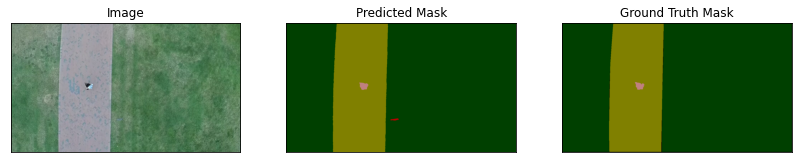

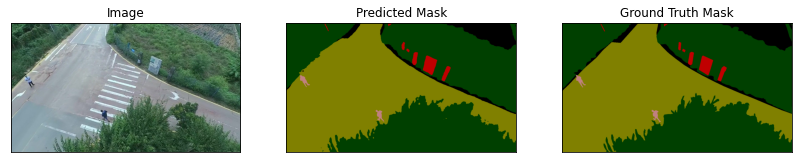

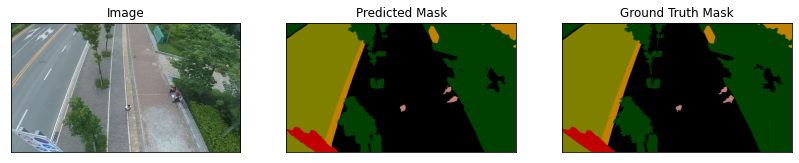

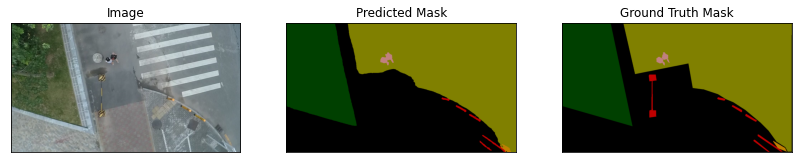

In [34]:
def predict(image_dict, visualize=True):
    #pr_mask = inferencer.predict_mask(image_dict)
    pr_mask = inferencer.predict(image_dict, activation="argmax").cpu().numpy()
    if visualize:
        Visualizer.visualize_images(
            image = image_dict["image_path"],
            predicted_mask = pr_mask,
            ground_truth_mask = image_dict["mask_path"]
        )
    return pr_mask


inferencer = Inferencer(cfg)
for image_dict in random.sample(inferencer.valid_image_dict_list, 4):
    predict(image_dict, visualize=True)

In [35]:
def evaluate_model(data_loader):
    metrics = IouAndDiceMetrics(Data.num_classes)
    pbar_loader = tqdm(data_loader)
    for images, gt_masks in pbar_loader:
        images = images.to(inferencer.device)
        gt_masks = gt_masks.narrow(2, 8, 720).to(inferencer.device)
        pr_masks = inferencer.predict(images)
        metrics.add(pr_masks, gt_masks)
        iou, _ = metrics.iou
        dice, _ = metrics.dice
        pbar_loader.set_postfix(iou=f"{iou:.03f}", dice=f"{dice:.03f}")
    pbar_loader.close()
    return metrics

def print_metrics(metrics):
    mean_iou, per_class_iou = metrics.iou
    print("  IoU Coefficients ")
    print("-------------------")
    print(f"        Mean: {mean_iou:.03f}")
    for class_name, class_iou in zip(Data.classes, per_class_iou):
        print(f"{class_name:>12}: {class_iou:.03f}")
    print()

    mean_dice, per_class_dice = metrics.dice
    print(" Dice Coefficients ")
    print("-------------------")
    print(f"        Mean: {mean_dice:.03f}")
    for class_name, class_dice in zip(Data.classes, per_class_dice):
        print(f"{class_name:>12}: {class_dice:.03f}")


#valid_metrics = evaluate_model(inferencer.valid_net_loader)
#print_metrics(valid_metrics)

## <font style="color:orange">Mean and Per-Class Dice Scores</font>

The following table enumerates the mean and per-class dice scores for the validation dataset. The classes with the lowest average score are Construction (0.738), Background (0.750), and Obstacle (0.820). From observing predictions on the test dataset, a lot of Obstacles are poorly classified.

```
EXPERIMENT                 MEAN  BACK  PERS  BIKE  CAR   DRONE BOAT  ANIM  OBST  CONST VEGE  ROAD  SKY
-------------------------  ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
AAA-FPN-EFF3-1C-FS-NA      0.792 0.803 0.872 0.885 0.960 0.968 0.135 0.923 0.827 0.452 0.943 0.923 0.811
AAB-FPN-EFF3-CA-FS-NA      0.843 0.803 0.867 0.891 0.930 0.360 0.961 0.904 0.831 0.874 0.924 0.928 0.838
AAC-FPN-EFF3-CA-FS-DA      0.883 0.756 0.851 0.889 0.955 0.960 0.877 0.929 0.793 0.818 0.942 0.916 0.904
AAD-FPN-EFF3-CA-T2-DA      0.875 0.773 0.864 0.897 0.973 0.982 0.995 0.991 0.827 0.452 0.901 0.855 0.986
ABA-FPN-RNS50-CA-T1-DA     0.916 0.774 0.870 0.897 0.965 0.981 0.996 0.991 0.828 0.872 0.950 0.888 0.984
ABB-DL3P-EFF3-CA-FS-DA     0.905 0.773 0.857 0.880 0.975 0.980 0.992 0.972 0.816 0.850 0.935 0.866 0.967
ABC-DL3P-EFF3-CA-T1-DA     0.914 0.784 0.869 0.889 0.974 0.985 0.991 0.990 0.819 0.864 0.946 0.871 0.985
ABD-DL3P-EFF5-CA-FS-DA     0.894 0.789 0.876 0.905 0.968 0.975 0.975 0.872 0.856 0.880 0.952 0.879 0.802
ABE-DL3P-RNT50-CA-FS-DA    0.900 0.759 0.857 0.875 0.972 0.982 0.994 0.983 0.779 0.831 0.939 0.839 0.992
ABF-DL3P-RNT50-CA-FS-CPW   0.893 0.762 0.849 0.873 0.961 0.980 0.988 0.975 0.771 0.798 0.944 0.835 0.978
ABG-DL3P-RNT50-CA-FS-CP5   0.888 0.749 0.831 0.876 0.968 0.981 0.988 0.972 0.726 0.786 0.940 0.852 0.990
ABH-DL3P-RNT152-CA-FS-DA   0.892 0.756 0.845 0.878 0.968 0.967 0.977 0.969 0.764 0.805 0.944 0.866 0.964
BAA-FPN-EFF3-CA-T1-DA      0.913 0.774 0.864 0.894 0.971 0.978 0.986 0.987 0.828 0.842 0.939 0.901 0.992
BAB-FPN-EFF3-CA-T1-DA      0.925 0.769 0.883 0.904 0.962 0.981 0.996 0.995 0.841 0.900 0.952 0.923 0.992
BAC-FPN-EFF3-CA-T1-DA      0.926 0.740 0.874 0.899 0.979 0.982 0.992 0.995 0.857 0.904 0.954 0.942 0.994
BAD-FPN-EFF3-CA-T1-DA      0.923 0.755 0.879 0.904 0.970 0.978 0.985 0.985 0.857 0.877 0.955 0.943 0.986
BAE-FPN-EFF3-CA-T1-DA      0.930 0.750 0.904 0.903 0.967 0.984 0.998 0.996 0.876 0.914 0.958 0.916 0.991
BBA-FPN-EFF3-FT-T1-DA      0.924 0.782 0.869 0.899 0.977 0.981 0.992 0.987 0.858 0.882 0.943 0.923 0.994
BBB-FPN-EFF3-FT-T1-DA      0.927 0.775 0.887 0.910 0.965 0.981 0.993 0.995 0.850 0.901 0.952 0.928 0.994
BBC-FPN-EFF3-FT-T1-DA      0.932 0.748 0.879 0.905 0.982 0.986 0.994 0.997 0.863 0.918 0.964 0.947 0.996
BBD-FPN-EFF3-FT-T1-DA      0.927 0.759 0.885 0.904 0.971 0.976 0.985 0.991 0.864 0.886 0.960 0.951 0.991
BBE-FPN-EFF3-FT-T1-DA      0.933 0.755 0.905 0.907 0.973 0.983 0.996 0.997 0.885 0.912 0.959 0.934 0.994
CAA-FPN-EFF3-CA-T1-DA-W1   0.878 0.787 0.878 0.896 0.974 0.986 0.995 0.987 0.850 0.452 0.918 0.819 0.990
CAB-FPN-EFF3-CA-T1-DA-W2   0.920 0.785 0.884 0.903 0.970 0.979 0.909 0.958 0.865 0.904 0.956 0.931 0.991
CAC-FPN-EFF3-CA-T1-DA-W3   0.792 0.000 0.856 0.894 0.972 0.982 0.990 0.962 0.867 0.452 0.887 0.653 0.994
CAD-FPN-EFF3-CA-T1-DA-W4   0.875 0.777 0.867 0.898 0.971 0.986 0.995 0.990 0.848 0.452 0.918 0.806 0.990
CAE-FPN-EFF3-CA-T1-DA-W5   0.930 0.795 0.879 0.895 0.972 0.984 0.996 0.991 0.865 0.885 0.959 0.944 0.996
DAA-FPN-EFF3-FT-T1-DA      0.924 0.784 0.867 0.898 0.977 0.981 0.996 0.988 0.854 0.878 0.947 0.923 0.996
DAB-FPN-EFF3-FT-FS-DA      0.921 0.782 0.870 0.898 0.978 0.981 0.992 0.990 0.851 0.858 0.945 0.916 0.996
DAC-FPN-EFF3-FT-FS-DA-W1   0.926 0.786 0.875 0.903 0.974 0.982 0.992 0.992 0.864 0.880 0.953 0.921 0.996
DAD-FPN-EFF3-FT-FS-DA-W2   0.927 0.788 0.871 0.905 0.975 0.981 0.994 0.990 0.863 0.879 0.954 0.932 0.992
DAE-FPN-EFF3-CA-FS-DA-W2   0.810 0.777 0.868 0.896 0.964 0.977 0.212 0.962 0.828 0.452 0.952 0.900 0.931
EBA-FPN-EFF3-CA-FS-DA      0.911 0.777 0.868 0.890 0.968 0.972 0.958 0.966 0.835 0.862 0.954 0.944 0.942
EBB-FPN-EFF3-CA-FS-CPR     0.872 0.754 0.848 0.877 0.931 0.970 0.877 0.908 0.780 0.817 0.943 0.923 0.830
EBC-FPN-EFF3-CA-FS-CPW     0.828 0.715 0.836 0.867 0.948 0.945 0.901 0.854 0.749 0.452 0.932 0.892 0.849
EBD-FPN-EFF3-CA-FS-CPW-WA  0.852 0.748 0.839 0.852 0.940 0.953 0.794 0.876 0.762 0.803 0.923 0.881 0.857
EDA-FPN-EFF3-CA-FS-DA      0.870 0.762 0.857 0.889 0.971 0.980 0.998 0.986 0.815 0.452 0.895 0.851 0.981
EDB-FPN-EFF3-CA-FS-CPR     0.847 0.737 0.826 0.869 0.969 0.977 0.954 0.980 0.730 0.452 0.876 0.815 0.977
EDC-FPN-EFF3-CA-FS-CPW     0.859 0.741 0.840 0.866 0.967 0.981 0.963 0.986 0.770 0.452 0.900 0.859 0.986
EDD-FPN-EFF3-CA-FS-CPW-WA  0.859 0.757 0.841 0.882 0.971 0.983 0.959 0.984 0.792 0.452 0.876 0.831 0.976
FBA-FPN-EFF3-CA-T1-DA      0.908 0.771 0.861 0.885 0.975 0.974 0.978 0.978 0.817 0.837 0.950 0.880 0.989
FBB-FPN-EFF3-CA-T1-CPR     0.913 0.776 0.857 0.887 0.970 0.975 0.957 0.985 0.830 0.879 0.951 0.903 0.987
FBC-FPN-EFF3-CA-T1-CPW     0.911 0.773 0.854 0.888 0.963 0.976 0.986 0.984 0.812 0.851 0.956 0.893 0.996
FBD-FPN-EFF3-CA-T1-CPW-WA  0.781 0.656 0.754 0.805 0.890 0.912 0.926 0.735 0.633 0.452 0.905 0.784 0.925
FDA-FPN-EFF3-CA-T1-DA      0.872 0.772 0.852 0.885 0.973 0.985 0.996 0.991 0.822 0.452 0.940 0.802 0.994
FDB-FPN-EFF3-CA-T1-CPR     0.868 0.767 0.840 0.890 0.959 0.983 0.988 0.988 0.816 0.452 0.941 0.793 0.993
FDC-FPN-EFF3-CA-T1-CPW     0.862 0.761 0.829 0.872 0.973 0.981 0.984 0.987 0.797 0.452 0.934 0.788 0.990
FDD-FPN-EFF3-CA-T1-CPW-WA  0.863 0.760 0.835 0.876 0.971 0.978 0.988 0.991 0.796 0.452 0.899 0.817 0.994
GAA-DL3P-RNT50-CA-T1-DA    0.915 0.782 0.868 0.888 0.967 0.982 0.990 0.986 0.819 0.856 0.940 0.912 0.990
GAB-DL3P-RNT50-CA-T1-DA    0.918 0.776 0.878 0.904 0.959 0.985 0.996 0.996 0.840 0.851 0.952 0.899 0.980
GAC-DL3P-RNT50-CA-T1-DA    0.907 0.723 0.857 0.878 0.971 0.984 0.996 0.997 0.810 0.794 0.945 0.943 0.991
GAD-DL3P-RNT50-CA-T1-DA    0.915 0.753 0.878 0.890 0.967 0.978 0.993 0.995 0.827 0.839 0.949 0.925 0.985
GAE-DL3P-RNT50-CA-T1-DA    0.908 0.738 0.887 0.882 0.957 0.985 0.998 0.994 0.824 0.809 0.950 0.891 0.987
HAA-LN-SK34-CA-T1-DA       0.895 0.775 0.865 0.885 0.968 0.981 0.976 0.958 0.815 0.833 0.889 0.814 0.977

                MINIMUM    0.781 0.000 0.754 0.805 0.890 0.360 0.135 0.735 0.633 0.452 0.876 0.653 0.802
                AVERAGE    0.891 0.750 0.862 0.888 0.966 0.966 0.945 0.969 0.820 0.738 0.937 0.882 0.966
                MAXIMUM    0.933 0.803 0.905 0.910 0.982 0.986 0.998 0.997 0.885 0.918 0.964 0.951 0.996
```

## <font style="color:orange">Ensemble</font>

Instances of the `Ensemble` class combine two or more models to increase the accuracy of predictions. Ensembles perform the following steps.

**Preparation**
- For each model in the ensemble:
  - For each image in the test dataset:
    - Predict the mask and apply softmax activation
    - Cache the pixel level probabilities to disk

**Inferencing on the GPU**
- Open probability caches for reading
- For each image in the test dataset:
  - Read normalized probabilities
  - Compute three masks by ...
      - (AP) Averaging each model's probabilities and selecting the class with the highest probability
      - (BP) Selecting the class with the highest probability across all models
      - (MW) Allowing each model to vote and break ties via probability

In [36]:
class Ensemble(object):
    _root_dir = "./ensemble"
    
    def __init__(self, configs, device=None, prepare=True):
        self.__files = None
        self.__device = device
        self.__configs = configs
        self.__prepared = False

        os.makedirs(Ensemble._root_dir, exist_ok=True)
        if prepare:
            self.prepare()

    @classmethod
    def __path(cls, config):
        return os.path.join(Ensemble._root_dir, Inferencer.name(config) + ".npy")        

    @property
    def predictions(self):
        if not self.__prepared:
            raise RuntimeError("Must first call the prepare() method.")
        if self.__files is None:
            raise RuntimeError("Must first call the open() method or get within a 'with' statement.")
        return self.Predictions(self.__files, self.__device)
            
    def open(self):
        self.__files = [open(Ensemble.__path(config), "rb") for config in self.__configs]
        
    def close(self):
        for file in self.__files:
            file.close()
        self.__files = None
    
    def __enter__(self):
        self.open()
        return self
    
    def __exit__(self, exc_type, exc_value, tb):
        self.close()
        return exc_type is None

    def prepare(self):
        self.__prepared = True
        for config in self.__configs:
            name = Inferencer.name(config)
            path = Ensemble.__path(config)
            if not os.path.isfile(path):
                inferencer = Inferencer(config)
                with open(path, "wb") as f:
                    pbar_loader = tqdm(inferencer.test_net_loader, desc=name, unit="batch")
                    for images, _ in pbar_loader:
                        images = images.to(inferencer.device)
                        predictions = inferencer.predict(images, activation="softmax").cpu().numpy()
                        for prediction in predictions:
                            np.save(f, prediction)
                    pbar_loader.close()
                del inferencer
                torch.cuda.empty_cache()
                
    class Predictions(object):
        def __init__(self, files, device):
            self.__files = files
            self.__image_ids = [d["name"] for d in Data.instance.get_prv_image_dict_list()]
            if device is None:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.__device = device

        def __len__(self):
            return len(self.__image_ids)

        def __iter__(self):
            self.__iter = iter(self.__image_ids)
            return self

        def __next__(self):
            from torch.nn import functional as f
            image_id = next(self.__iter, None)
            if image_id is None:
                raise StopIteration
            probs = np.stack([np.load(f) for f in self.__files], axis=-1)
            probs = torch.from_numpy(probs.transpose(3, 0, 1, 2)).to(self.__device)
            num_preds, num_classes, image_height, image_width = tuple(probs.shape)
            amax = torch.amax(probs, dim=0)
            mask_ap = torch.argmax(torch.mean(probs, dim=0), dim=0)
            mask_bp = torch.argmax(amax, dim=0)
            mask_mw = torch.argmax(probs.view(num_preds, num_classes, -1), dim=1)
            mask_mw = f.one_hot(mask_mw, num_classes).transpose(1, 2).view(num_preds, num_classes, image_height, -1)
            mask_mw = torch.argmax(torch.sum(mask_mw, dim=0) + amax, dim=0)
            return image_id, mask_ap, mask_bp, mask_mw

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

## <font style="color:orange">Submission</font>

Instances of the `Submission` class prepare a submission file. A data loader is employed to optimize inferencing. The encoding process, however, is the bottleneck. Given Python threads do not use multiple CPUs, it would be worthwhile to investigate encoding on different processes. I assume PyTorch data loaders use a similar approach. This `create` method accepts an iterable. Instances of the `SubmissionInferenceIterable` class use an inferencer to make predictions. Instances of the `SubmissionEnsembleIterable` class use an ensemble to make predictions.

In [37]:
class Submission(object):
    root_dir = "./submissions"
    csv_fields = ("ImageID", "EncodedPixels")
    
    @classmethod
    def __encode(cls, binary_array):
        from itertools import accumulate, groupby

        # compute the length of "0" and "1" pixel runs
        lengths = []
        for i, (value, elements) in enumerate(groupby(binary_array.ravel())):
            if i == 0 and value == 1:
                lengths.append(0)
            lengths.append(len(list(elements)))

        # compute the offsets of the pixel runs
        offsets = list(accumulate([0] + lengths))[:-1]

        # discard the offsets and lengths that correspond to the "0" pixels
        lengths = lengths[1::2]
        offsets = offsets[1::2]

        # interleave the offsets and lengths and convert to a string
        encoding = [val for pair in zip(offsets, lengths) for val in pair]
        return ' '.join(map(str, encoding))
    
    @classmethod
    def create(cls, fname, iterable):
        import csv
        os.makedirs(Submission.root_dir, exist_ok=True)
        path = os.path.join(Submission.root_dir, fname)
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(Submission.csv_fields)
            pbar_test_iter = tqdm(iterable, desc="Encoding", unit="image")
            for name, pred in pbar_test_iter:
                rows = [(f"{name}_{idx}", cls.__encode(ba)) for idx, ba in enumerate(pred)]
                writer.writerows(rows)
            pbar_test_iter.close()
    

class SubmissionInferenceIterable(object):
    def __init__(self, inferencer):
        self.__inferencer = inferencer
        self.__image_ids = [d["name"] for d in Data.instance.get_prv_image_dict_list()]
    def __len__(self):
        return Data.prv_image_dict_len
    def __iter__(self):
        name_iter = iter(self.__image_ids)
        for images, _ in self.__inferencer.test_net_loader:
            preds = self.__inferencer.predict(images, activation="one_hot").cpu().numpy()
            for pred in preds:
                name = next(name_iter)
                yield name, pred

class SubmissionEnsembleIterable(object):
    def __init__(self, ensemble, num_classes, method):
        self.__ensemble = ensemble
        self.__num_classes = num_classes
        if method == "ap":
            self.__pred_idx = 1
        elif method == "bp":
            self.__pred_idx = 2
        elif method == "mw":
            self.__pred_idx = 3
        else:
            raise ValueError("The method parameter should be 'ap', 'bp', or 'mw'.")
    def __len__(self):
        return Data.prv_image_dict_len
    def __iter__(self):
        from torch.nn import functional as f
        with self.__ensemble:
            for prediction in self.__ensemble.predictions:
                name = prediction[0] 
                pred = prediction[self.__pred_idx]
                pred = f.one_hot(pred, self.__num_classes).cpu().numpy().transpose(2, 0, 1)
                yield name, pred
                

#configs = (ExpBAA(), ExpBAB(), ExpBAC(), ExpBAD(), 
#           ExpBAE(), ExpABA(), ExpABB(), ExpABC())
#Submission.create("ensemble01.csv", SubmissionEnsembleIterable(Ensemble(configs), Data.num_classes, "ap"))

In [38]:
#init_kaggle()
#!kaggle competitions submit -c opencv-pytorch-course-segmentation -f ./submissions/ensemble01.csv -m "Experiments BAA, BAB, BAC, BAD, BAE, ABA, ABB, ABC"

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

## <font style="color:orange">Kaggle, TensorBoard, and GitHub Links</font>

My Kaggle profile and the InClass Prediction Competition leaderboard links are below.
* [Kaggle Profile](https://www.kaggle.com/kevinkramer) 
* [OpenCV Pytorch Course - Classification Competition Leaderboard](https://www.kaggle.com/c/opencv-pytorch-course-segmentation/leaderboard)

 You can view the project's TensorBoard scalar logs and GitHub repository via the following links.
* [TensorBoard scalar logs](https://tensorboard.dev/experiment/wxVKOvcqRjO6hDEXUVlXzQ/)
* [GitHub repository](https://github.com/blazingcayenne/deep_learning_with_pytorch_project4)